# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
!pip install missingno

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', 100)
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
azdias.HEALTH_TYP

0        -1
1         3
2         3
3         2
4         3
5         3
6         2
7         1
8         3
9         2
10        2
11       -1
12        1
13        3
14       -1
15        2
16        3
17       -1
18        2
19        3
20        3
21        2
22        2
23        3
24       -1
25        2
26        1
27        3
28        3
29        2
         ..
891191    2
891192    1
891193    2
891194    3
891195    2
891196    2
891197    1
891198    3
891199    3
891200    3
891201    3
891202    2
891203    2
891204    3
891205    2
891206    3
891207    1
891208    1
891209    3
891210    3
891211    3
891212    1
891213    1
891214    3
891215    2
891216    3
891217   -1
891218    1
891219    1
891220    2
Name: HEALTH_TYP, Length: 891221, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# making copy of the original Frame
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [10]:
feat_info[feat_info.attribute == "INNENSTADT"].iloc[0,-1]

'[-1]'

In [11]:
string = '[-1,XX,9]'
string_list = string[1:-1].split(",")
string_list
for element in string_list:
    if element.isdigit():
        print("digit")

digit


In [12]:
# making string to array in feat_info

def string_to_array(df):
    string = df['missing_or_unknown']
    string_list = string[1:-1].split(",")
    
    converted_list = list()
    for element in string_list:
        if any(char.isdigit() for char in element):
            converted_list.append(int(element))
        else:
            converted_list.append(element)
    return converted_list

feat_info_clean['missing_numerical'] = feat_info_clean.apply(string_to_array,axis=1)
    

In [13]:
feat_info_clean.missing_numerical.iloc[59]

[-1, 'XX']

In [14]:
# Identify missing or unknown data values and replace them to NaNs.
for col in azdias_clean.columns:
    missing_labels = feat_info_clean[feat_info_clean.attribute == col].iloc[0,-1]
    azdias_clean[col] = azdias_clean[col].replace(missing_labels, np.nan)

In [15]:
# Check for the first column how many non NaN should probably be in the cleaned dataframe
len(azdias) - azdias.AGER_TYP.isin([0,-1]).sum()

205378

In [16]:
# Checking an example where "XX" is also an indicator for missing values
azdias_clean.iloc[59].isin([-1, "XX"]).sum()

0

In [17]:
# Ager_typ in the cleaned Data has 205378 entries as expected
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

There some columns astype object:

CAMEO_DEUG_2015, CAMEO_DEU_2015 and CAMEO_INTL_2015

In [18]:
# check what values are representing that columns
azdias_clean["CAMEO_DEUG_2015"].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3'], dtype=object)

In [19]:
azdias_clean["CAMEO_DEU_2015"].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [20]:
azdias_clean.CAMEO_INTL_2015.unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_clean.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [22]:
azdias_clean.isnull().sum().sum()

8373929

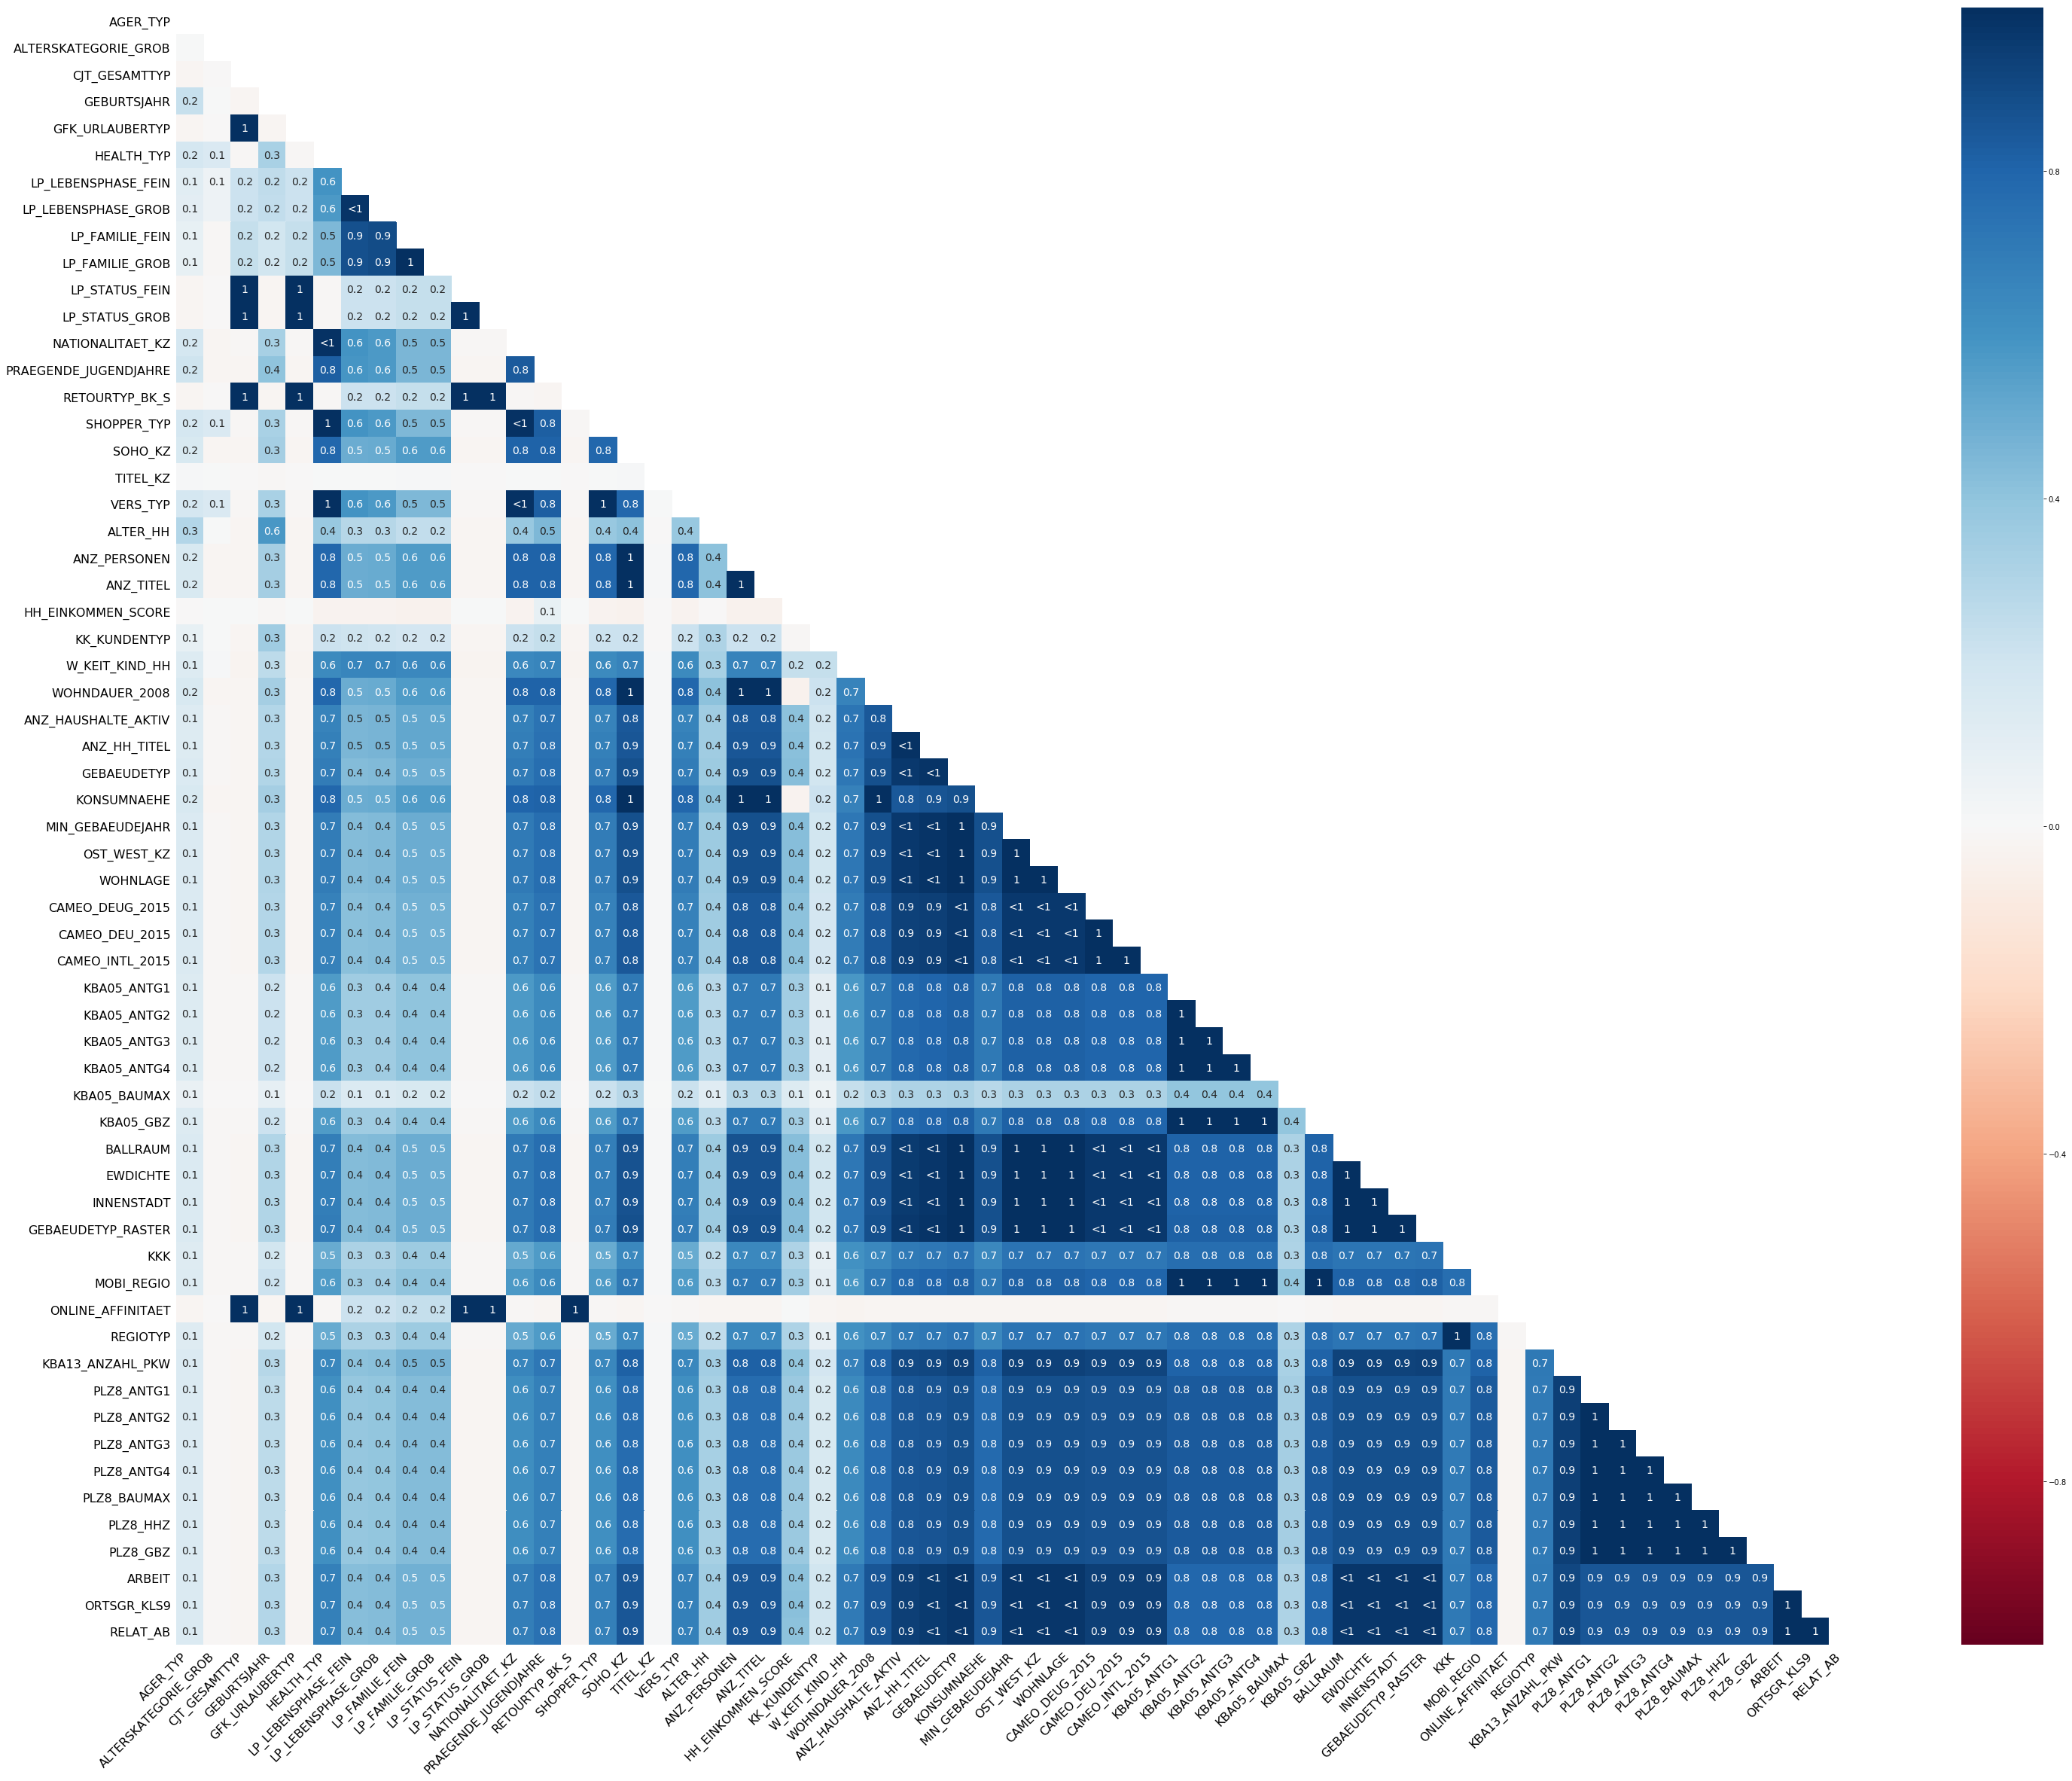

In [23]:
# A value near -1 means if one variable appears then the other variable is very likely to be missing.
# A value near 0 means there is no dependence between the occurrence of missing values of two variables.
# A value near 1 means if one variable appears then the other variable is very likely to be present. resource: Missingno

msno.heatmap(azdias_clean, figsize=(50,40));

The whole heatmap is visually white or blue. That means that all Correlation values are over 0. 
Information: 
- A value near -1 means if one variable appears then the other variable is very likely to be missing.
- A value near 0 means there is no dependence between the occurrence of missing values of two variables.
- A value near 1 means if one variable appears then the other variable is very likely to be present. resource: Missingno

So there are some correlation between those values. i.e. KBA_ANTG1, KBA_ANTG2, KBA_ANTG3, KBA_ANTG4 show us a 1.0. So if KBA_ANTG1 appears it's very likely that there is value for KBA_ANTG2, KBA_ANTG3, KBA_ANTG4 present. Let's take a look on the Distribution of missing values for each column



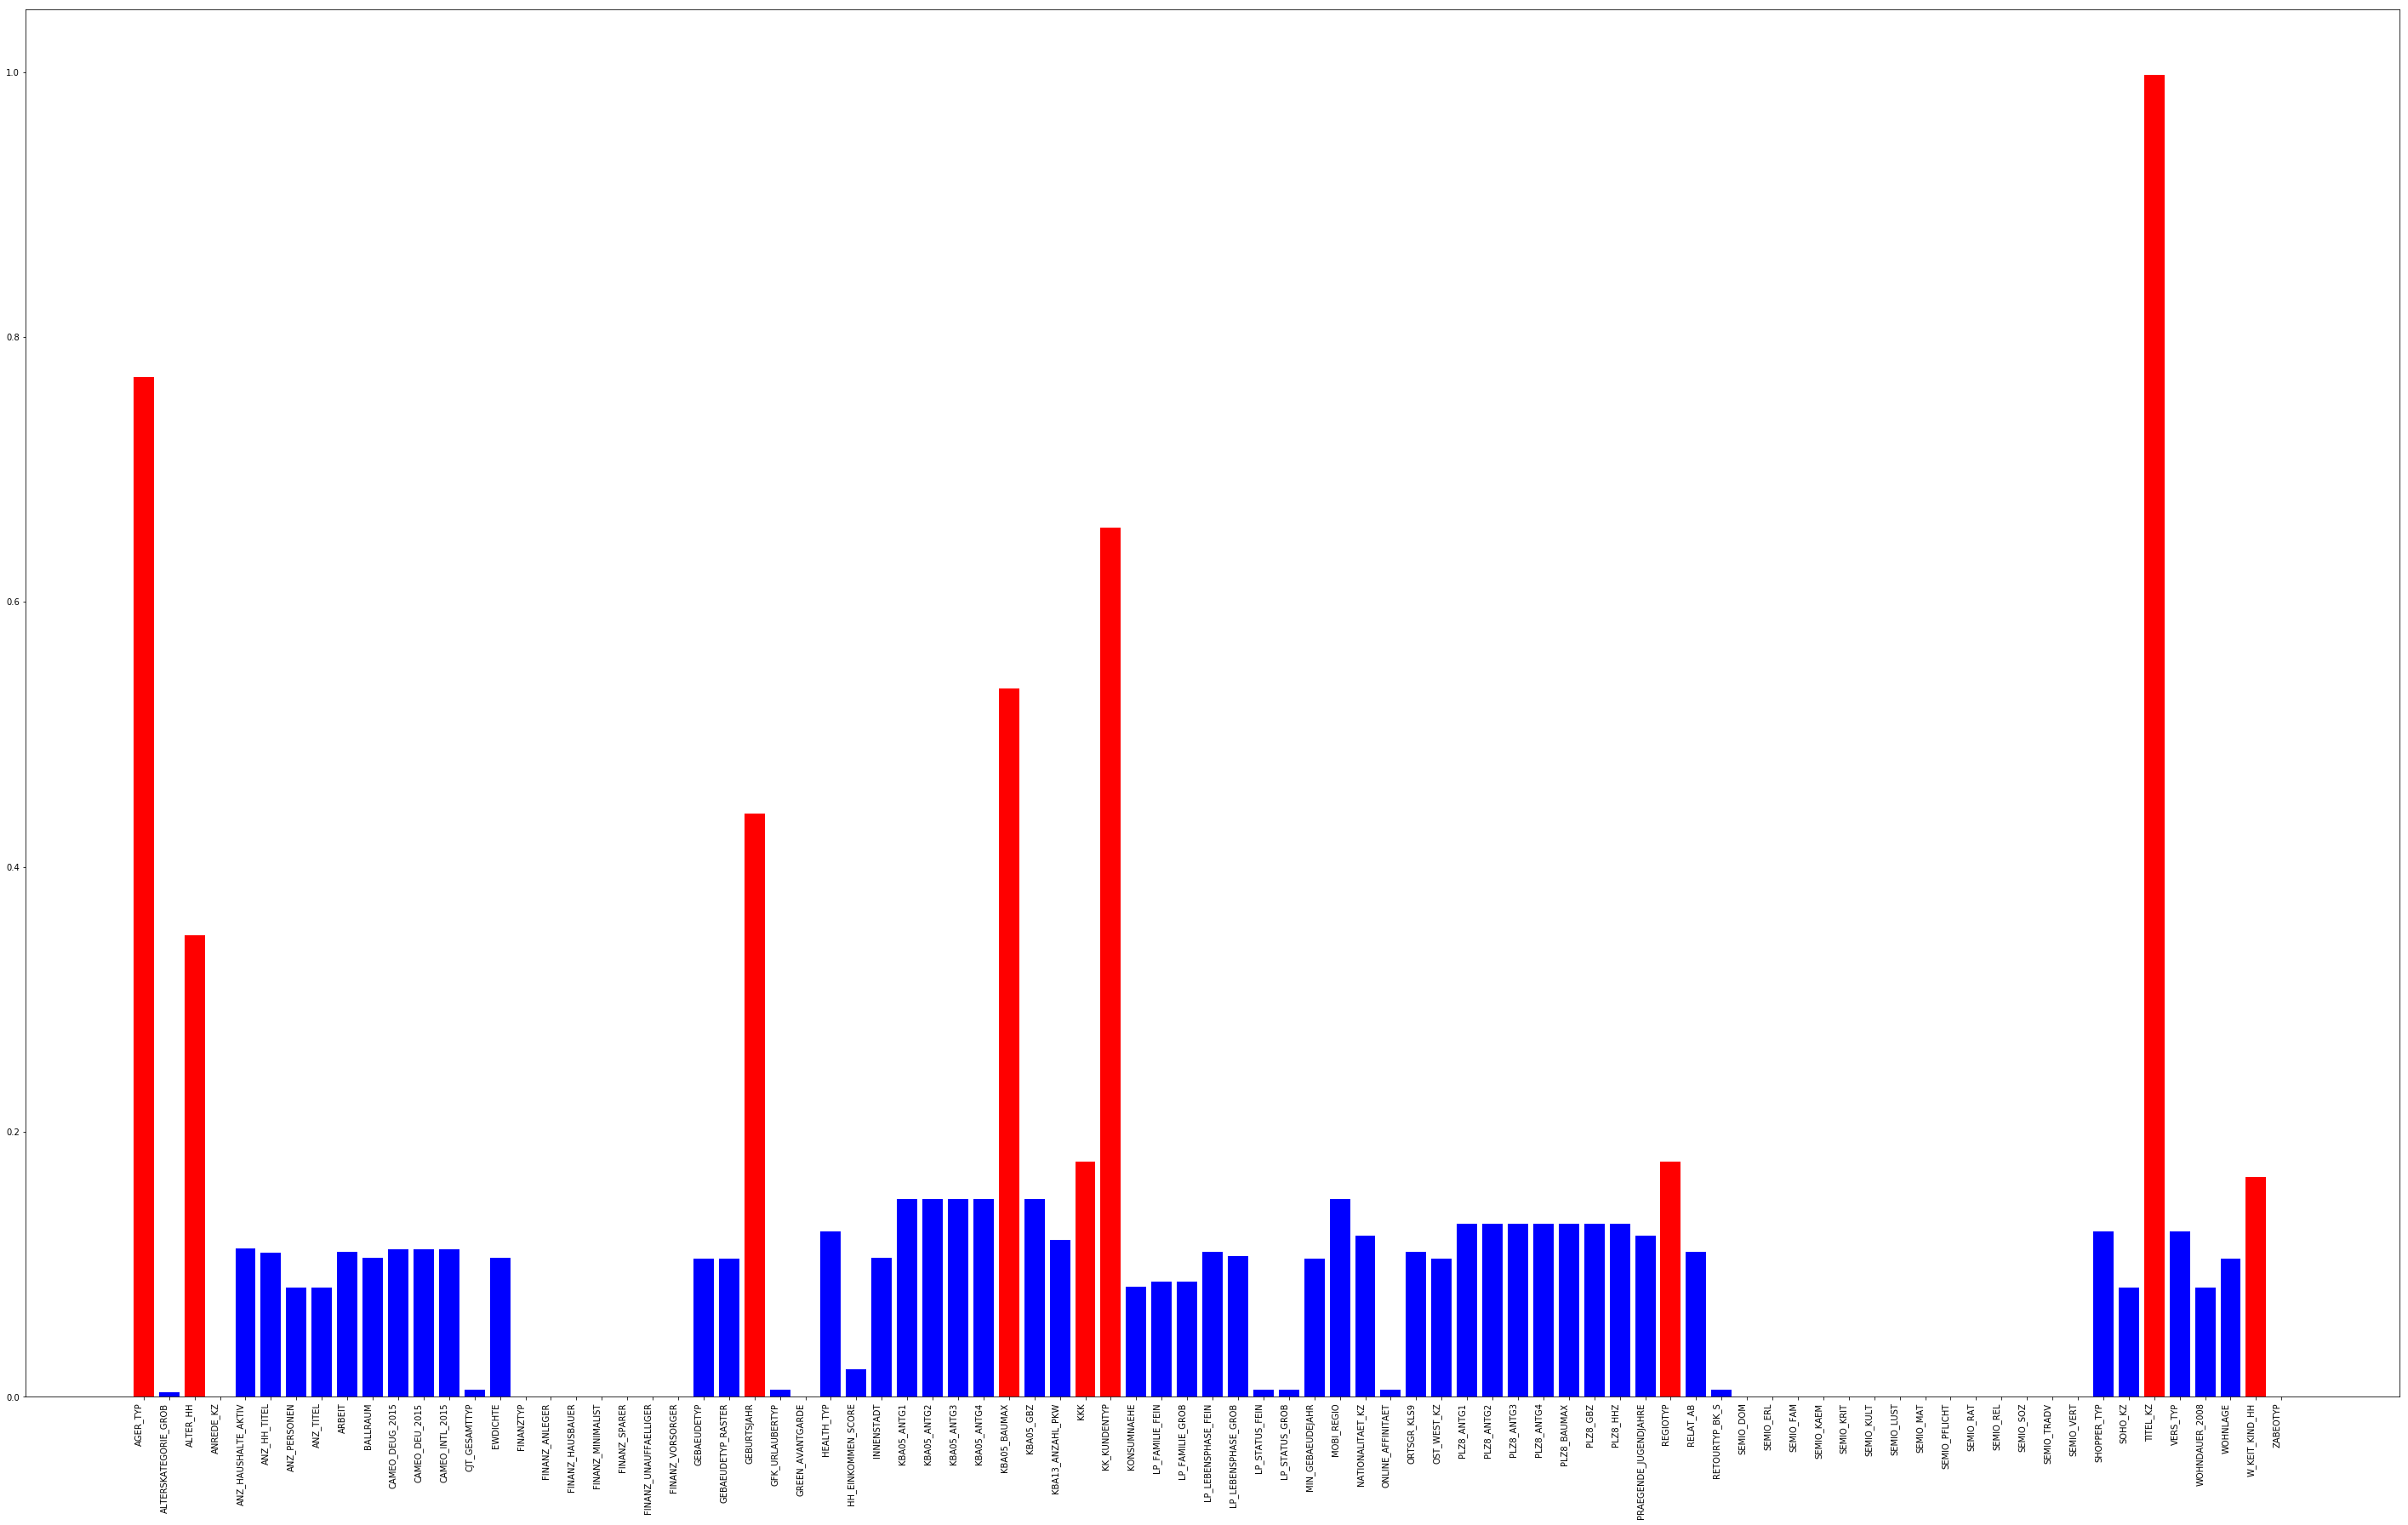

In [24]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(50,30))
total_size = len(azdias_clean)
missing_values_proportion = azdias_clean.isnull().sum() / total_size


# randomly chosen threshold for beeing marked as an outlier in the bar chart
threshold = missing_values_proportion.mean() * 1.5
color_cond = ["r" if nan_val > threshold else "b" for nan_val in missing_values_proportion]
plt.bar(missing_values_proportion.index, missing_values_proportion , color=color_cond)
plt.xticks(rotation=90, ha='right')
plt.show()

In [25]:
# Looking for the outlier columns
missing_values_proportion[missing_values_proportion > threshold].sort_values(ascending=False)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
dtype: float64

There are some "outlier-columns" which contains a lot of NaN. All columns with a proportion of over 50% NANs can be dropped. Also GEBURTSJAHR(Birthyear) can possibly be dropped cause we have an estimated Age category instead. The other columns stay in the dataframe. There some patterns regocnizable patterns in the distribution. All columns with similar names (like KBA05_ or CAMEO_) have similar or the same proportion of missing values. I'm guessing, that the missing values are in the same row.

In [26]:
# For example KBA05_
azdias_clean[azdias_clean.KBA05_ANTG1.isnull()].head(10)[["KBA05_ANTG1", "KBA05_ANTG2", "KBA05_ANTG3", "KBA05_ANTG4"]]

,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4
0,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN


In [27]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_cols = list(missing_values_proportion[missing_values_proportion > 0.4].index)

In [28]:
outlier_cols

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

In [29]:
azdias_clean.drop(columns=outlier_cols, inplace=True)

In [30]:
# Dropping 5 Columns, so in total 80 columns in the cleaned Dataframe
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

- There some columns which contains a lot of misssing values. Columns like 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX' got dropped cause of a proportion of missing values over 40%. (REMOVED)

- you can observe that there are some pattern in missing values if the columnsname are similar like PLZ8_, KBA05_, CAMEO_, 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?
nan_per_row = azdias_clean.isnull().sum(axis=1)
avg_nan = nan_per_row.mean()

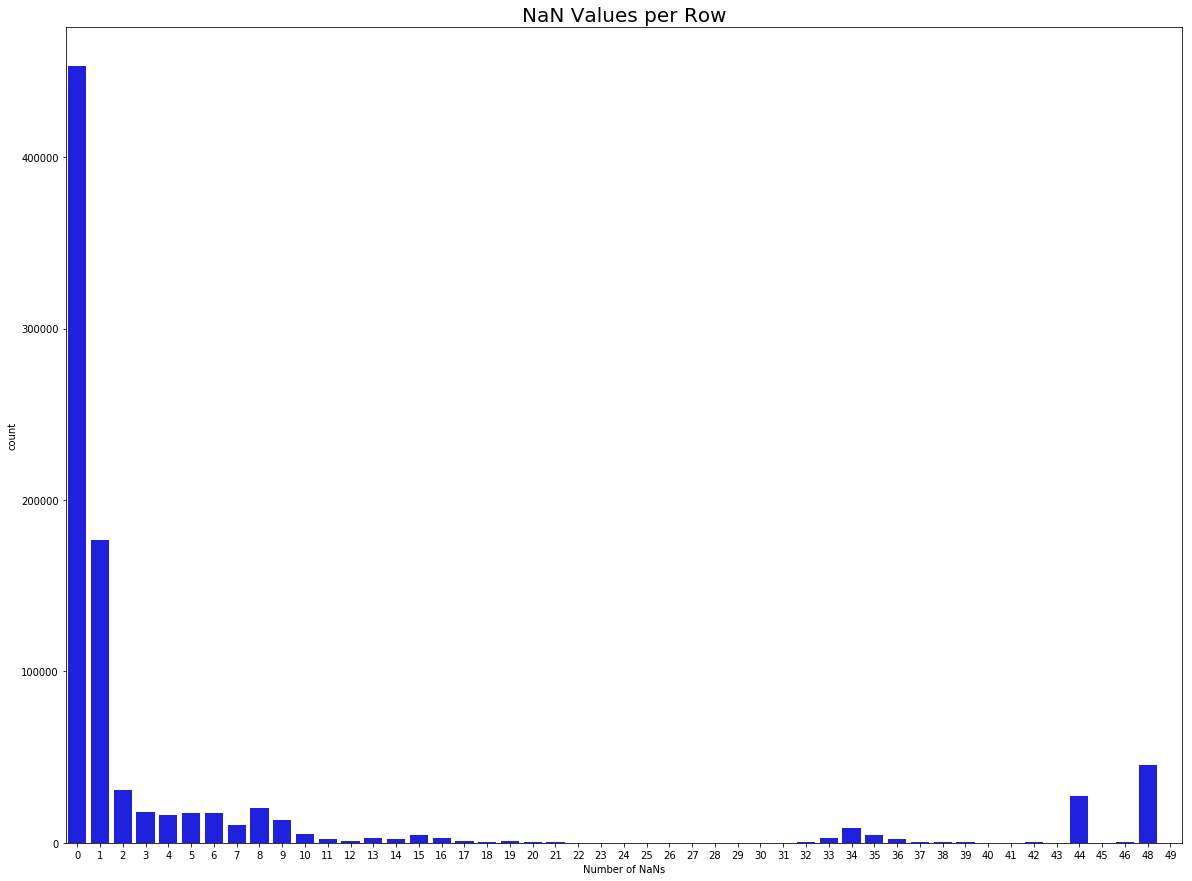

In [32]:
# Countplot of NaN per row
plt.figure(figsize=(20,15))
sns.countplot(nan_per_row, color="b")
plt.title("NaN Values per Row", size=20)
plt.xlabel("Number of NaNs")
plt.show()

##### FIXED!
Assign a fixed number to threshold

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Threshold at 10 missing values per row
threshold = 10

subset_clean = azdias_clean[nan_per_row <= threshold]
subset_many_nan = azdias_clean[nan_per_row > threshold]

In [34]:
# max amount of NaNs in the dataset per row
subset_clean.isnull().sum(axis=1).max()

10

In [35]:
# extract indices where at least 95% values are non NAN.
check_subset = subset_many_nan.loc[:, subset_many_nan.notnull().mean() > 0.90]

In [36]:
check_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112876 entries, 0 to 891203
Data columns (total 31 columns):
ALTERSKATEGORIE_GROB     112615 non-null float64
ANREDE_KZ                112876 non-null int64
CJT_GESAMTTYP            111145 non-null float64
FINANZ_MINIMALIST        112876 non-null int64
FINANZ_SPARER            112876 non-null int64
FINANZ_VORSORGER         112876 non-null int64
FINANZ_ANLEGER           112876 non-null int64
FINANZ_UNAUFFAELLIGER    112876 non-null int64
FINANZ_HAUSBAUER         112876 non-null int64
FINANZTYP                112876 non-null int64
GFK_URLAUBERTYP          111145 non-null float64
GREEN_AVANTGARDE         112876 non-null int64
LP_STATUS_FEIN           111145 non-null float64
LP_STATUS_GROB           111145 non-null float64
RETOURTYP_BK_S           111145 non-null float64
SEMIO_SOZ                112876 non-null int64
SEMIO_FAM                112876 non-null int64
SEMIO_REL                112876 non-null int64
SEMIO_MAT                112876

In [37]:
def subplot_features_count(df_clean, df_check, col_names):
    """Making a subplot of a specific column. To compare the Count Distribution between two dataframes
    Input: Two Dataframes and a list of column names
    Output: Plot the Proportion of the labels per column for each Dataframe"""
    for col in col_names:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        sns.countplot(df_clean[col], ax=ax1)
        ax1.set_title("'Cleaned' Subset")
        sns.countplot(df_check[col], ax=ax2)
        ax2.set_title("Dropping Subset")
        fig.suptitle(col +" Comparison", y=1.05)
        plt.tight_layout()
        plt.show
        
def subplot_features_proportion(df_clean, df_check, col_names):
    """Making a subplot of a specific column. To compare the relative Distribution between two dataframes
    Input: Two Dataframes and a list of column names
    Output: Plot the Proportion of the labels per column for each Dataframe"""
    for col in col_names:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
        proportion_1 = (df_clean[col].value_counts() / len(df_clean)).sort_index()
        sns.barplot(x = proportion_1.index, y=proportion_1, ax=ax1)
        ax1.set_title("'Cleaned' Subset")
        proportion_2 = (df_check[col].value_counts() / len(df_check)).sort_index()
        sns.barplot(x = proportion_2.index, y=proportion_2, ax=ax2)
        ax2.set_title("Dropping Subset")
        fig.suptitle(col +" Comparison", y=1.05)
        plt.ylim(0,1.0)
        plt.tight_layout()
        plt.show

In [38]:
columns_names = list(check_subset.columns)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


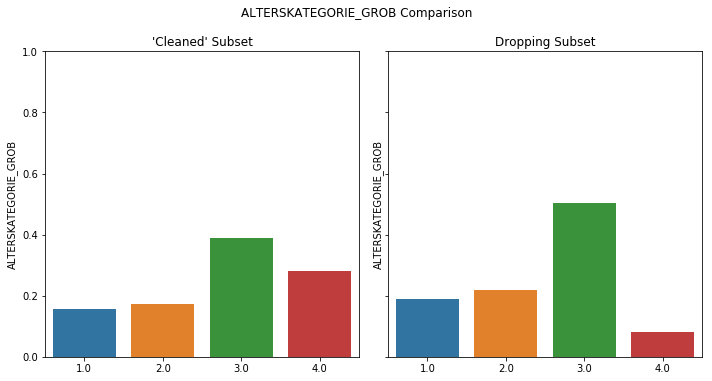

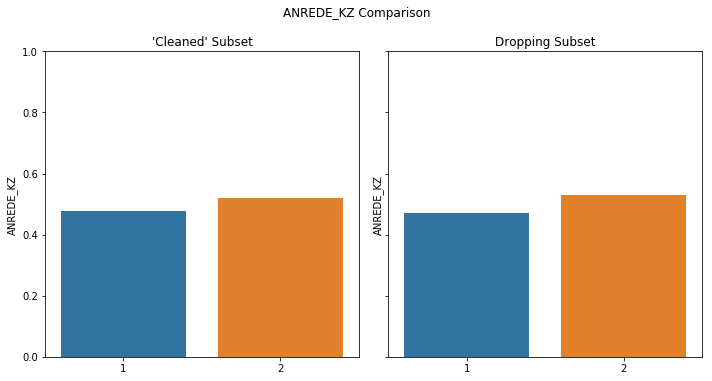

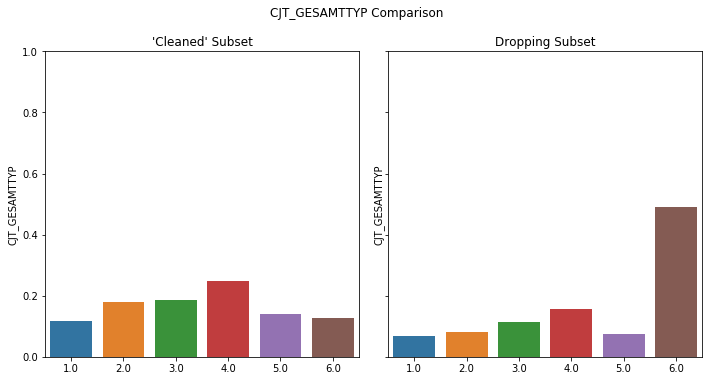

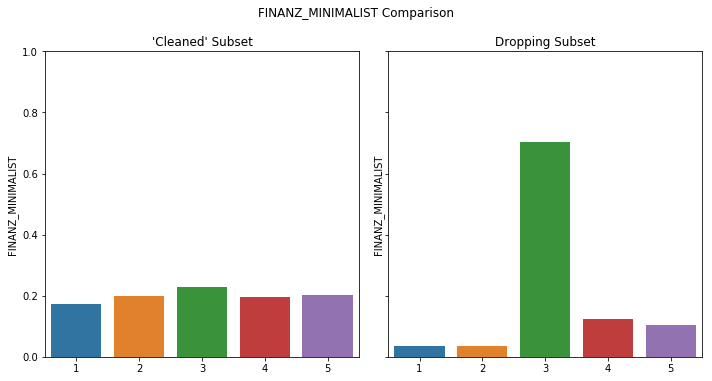

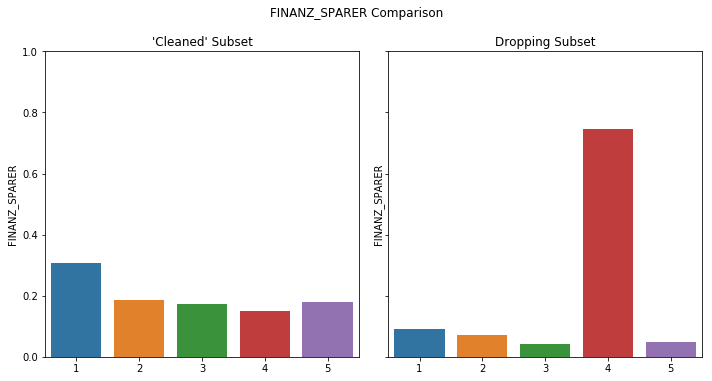

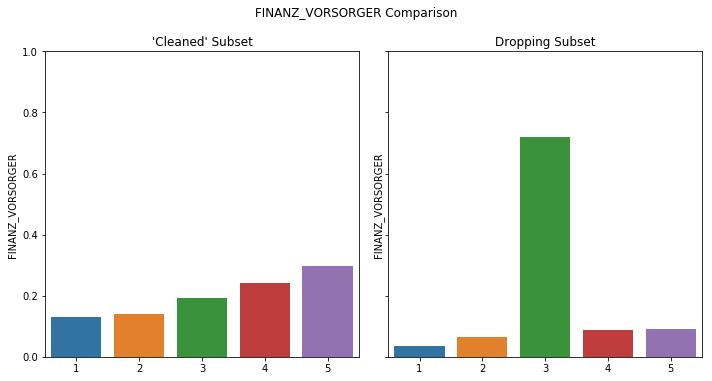

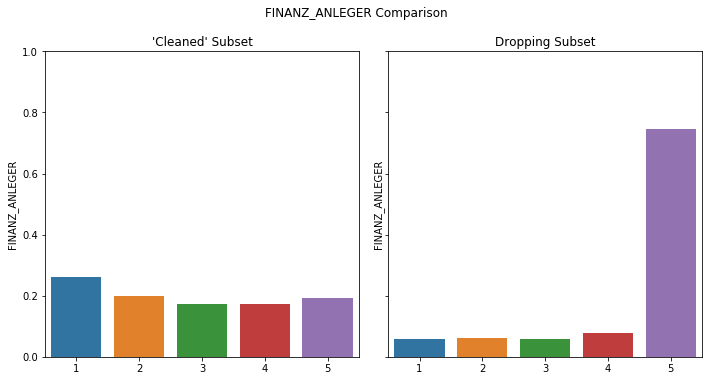

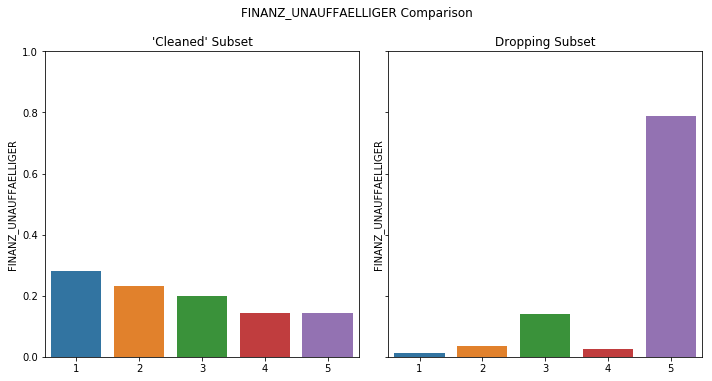

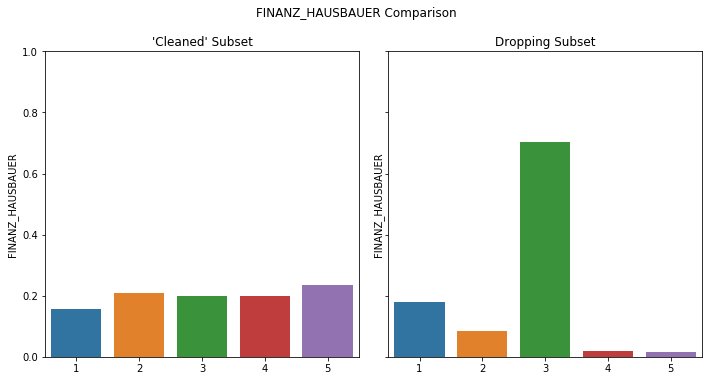

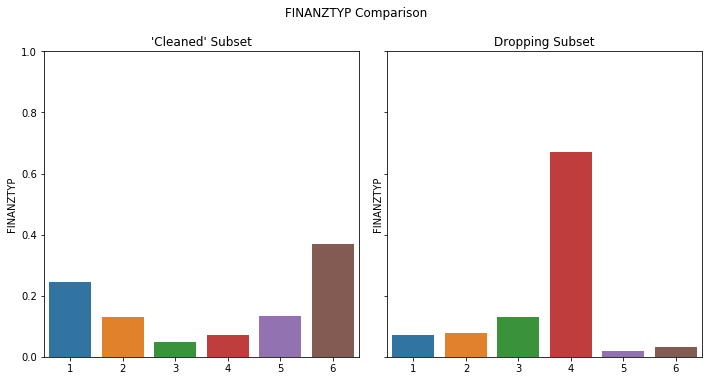

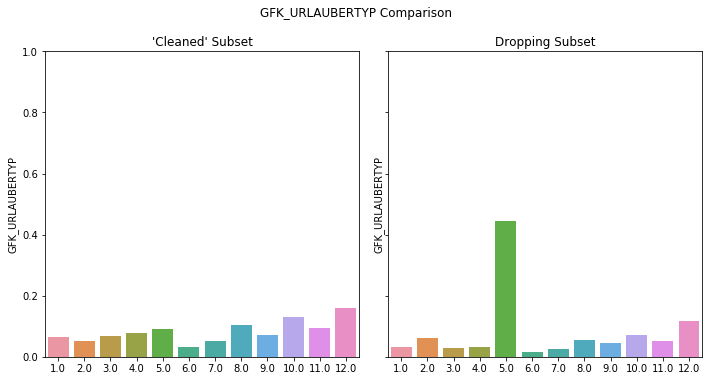

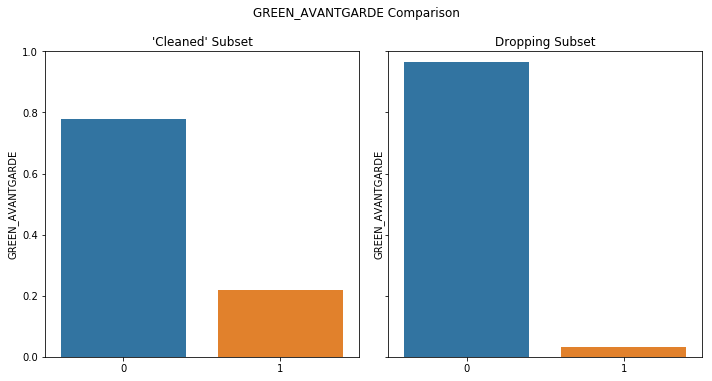

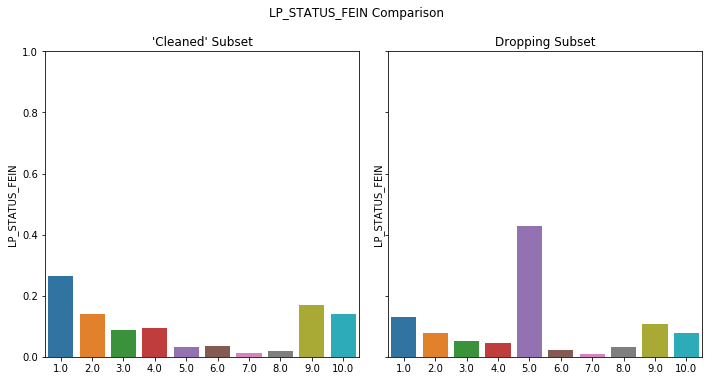

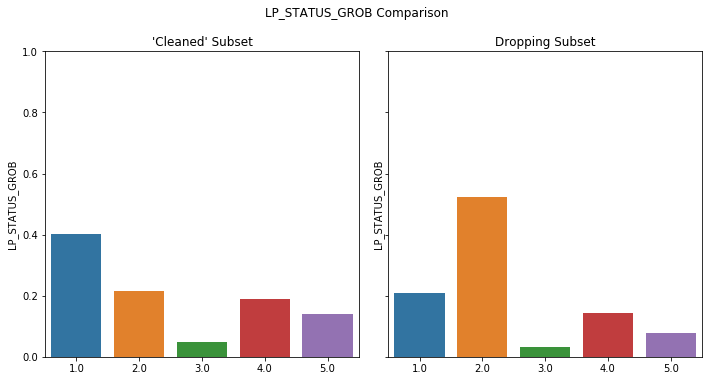

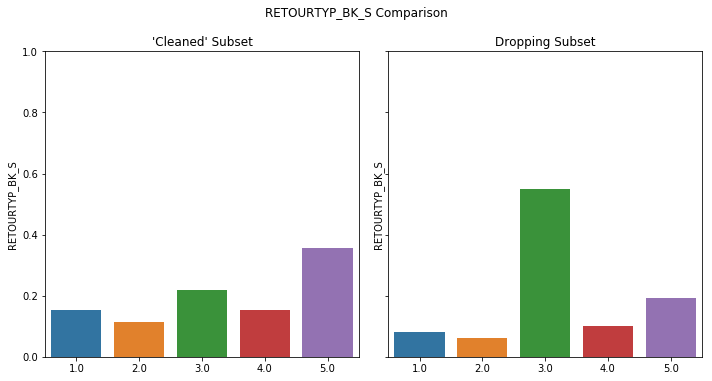

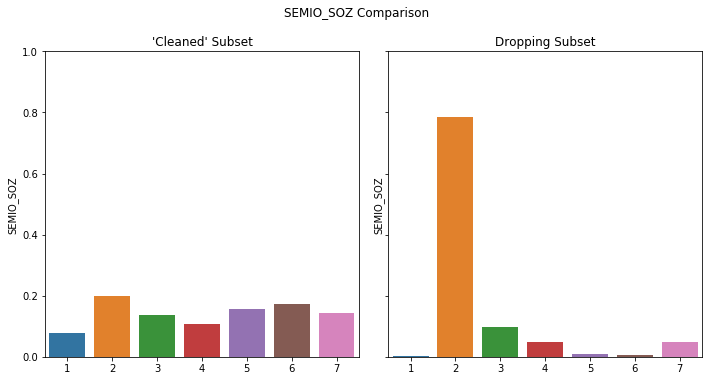

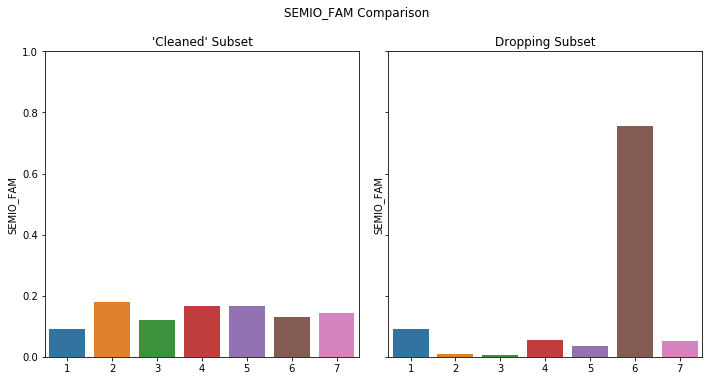

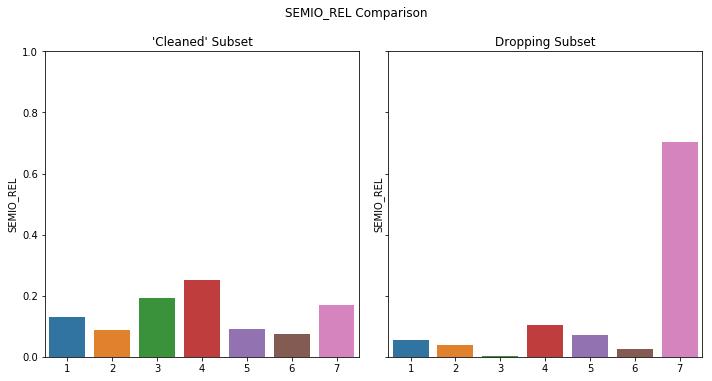

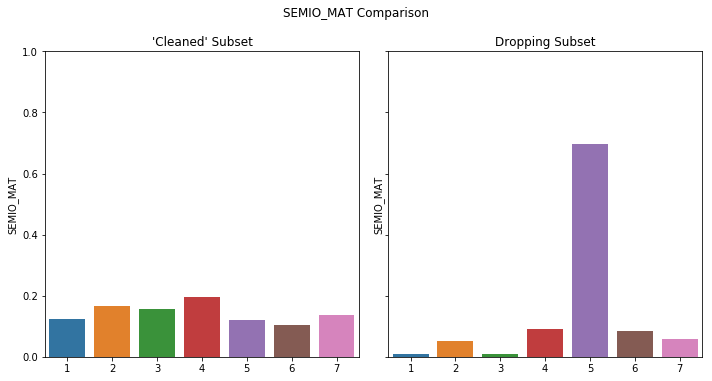

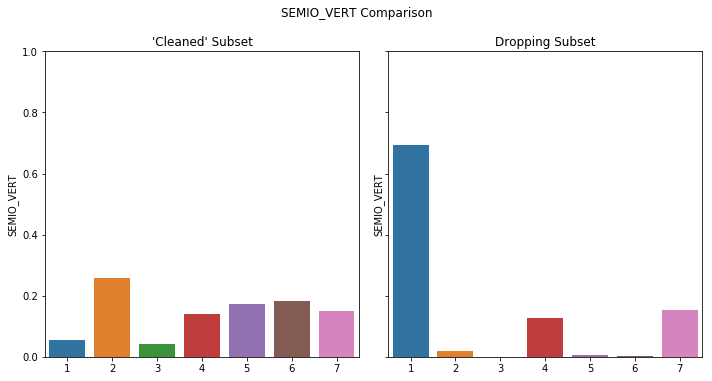

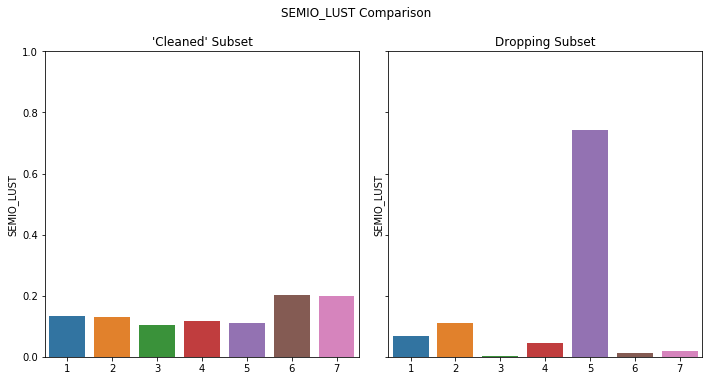

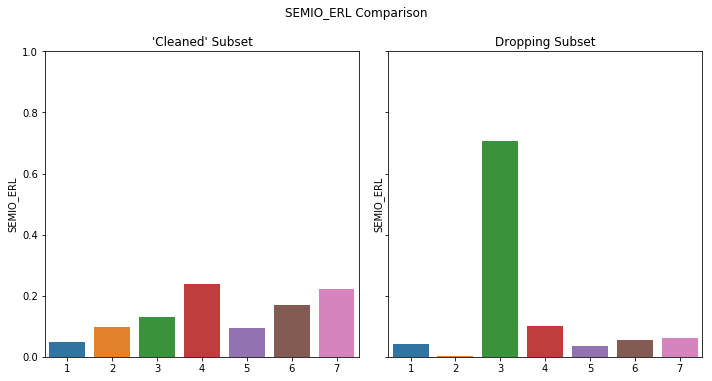

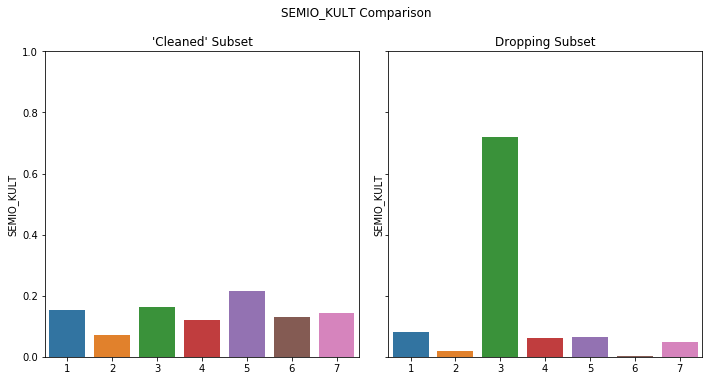

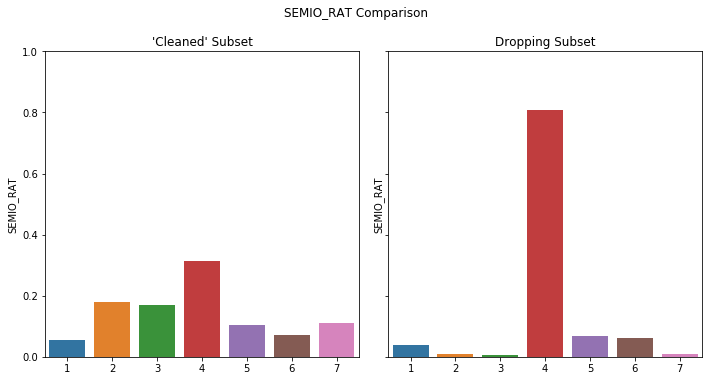

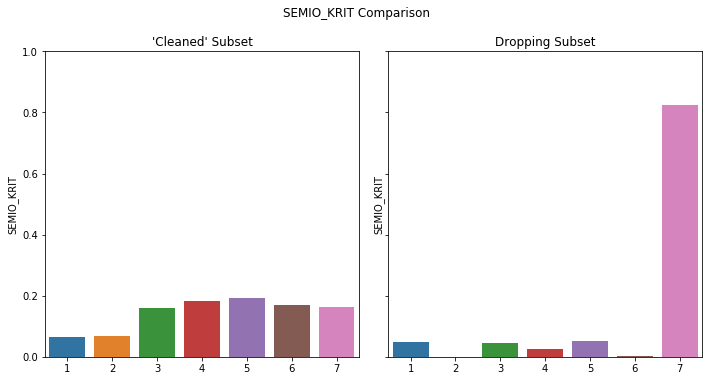

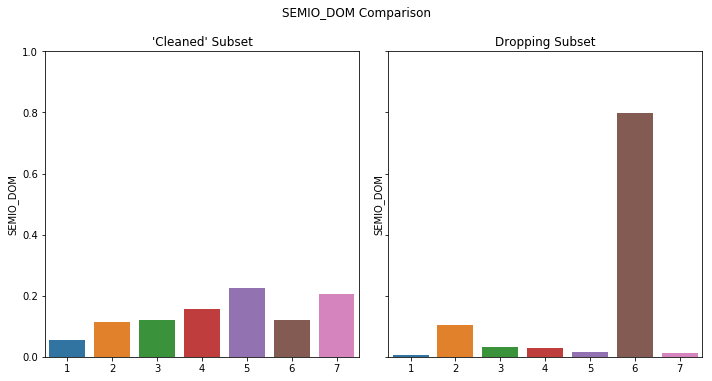

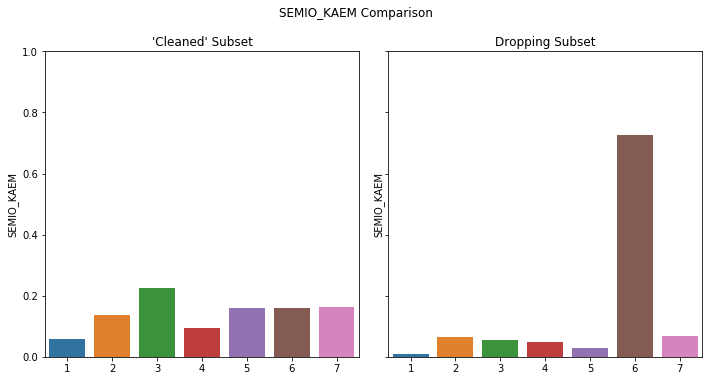

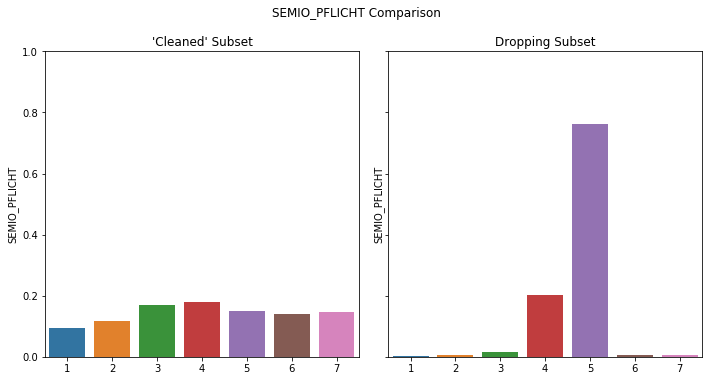

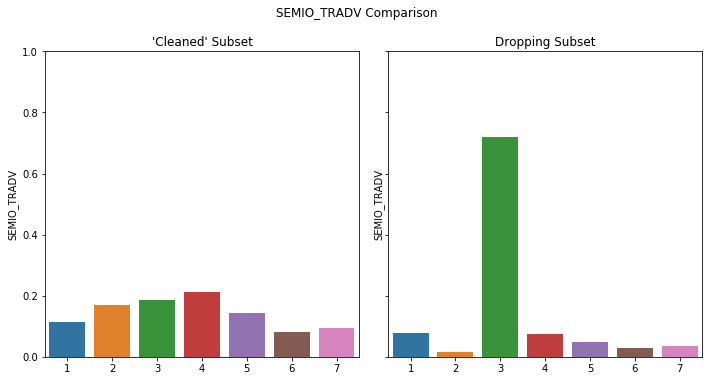

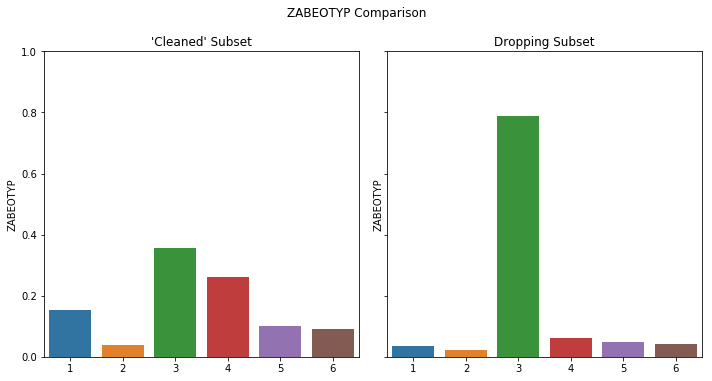

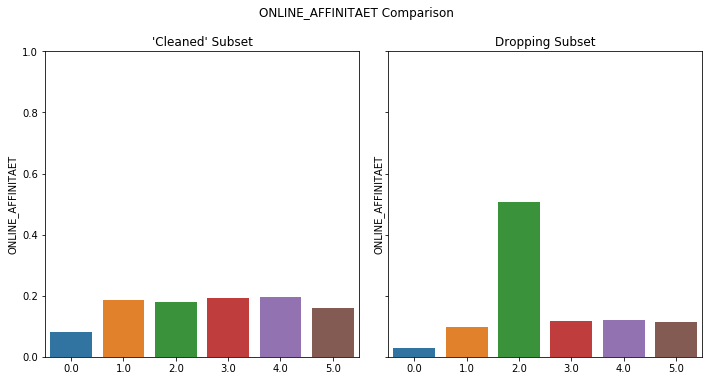

In [39]:
subplot_features_proportion(subset_clean, check_subset, col_names=columns_names);

In [39]:
# subplot_features_count(subset_clean, check_subset, col_names=["SEMIO_LUST", "SEMIO_TRADV"])

#### Discussion 1.1.3: Assess Missing Data in Each Row

There are some similiarties in the proportions between the two dataframes. But it's often that one label for a category is dominating the distribution(in the dropping subset)

###### Alterskategorie:
 - In the dropping frame is a high amount of 46-60 years old people in comparison to the "cleaned" subset
 
###### Anrede
 - The distribution of male and female is similar
 
###### Finanz_XXX
- The information of the financial typology is sometimes similar but as mentioned one label is highly dense in the proportion. I.E. Finanz_Anleger has in the dropping frame a high proportion of "very low" financial typoplogy

###### Urlaubstyp
- nearly the same distribtion with one exception in the dropping df. In this dataframe is a high amount of "nature fans" in the vacation type 

###### Semio_XXX
- like Finanz_XXX

###### Online_Affinität
- similar proportion with one exception. There is high amount of middle labeled online affinity

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
subset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778345 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     775725 non-null float64
ANREDE_KZ                778345 non-null int64
CJT_GESAMTTYP            775222 non-null float64
FINANZ_MINIMALIST        778345 non-null int64
FINANZ_SPARER            778345 non-null int64
FINANZ_VORSORGER         778345 non-null int64
FINANZ_ANLEGER           778345 non-null int64
FINANZ_UNAUFFAELLIGER    778345 non-null int64
FINANZ_HAUSBAUER         778345 non-null int64
FINANZTYP                778345 non-null int64
GFK_URLAUBERTYP          775222 non-null float64
GREEN_AVANTGARDE         778345 non-null int64
HEALTH_TYP               744682 non-null float64
LP_LEBENSPHASE_FEIN      733357 non-null float64
LP_LEBENSPHASE_GROB      736028 non-null float64
LP_FAMILIE_FEIN          750683 non-null float64
LP_FAMILIE_GROB          750683 non-null float64
LP_STATUS_FEIN           775222 non-null float64
LP_STATUS_GROB           

In [41]:
# How many features are there of each data type?
subset_clean.dtypes.value_counts()

float64    52
int64      24
object      4
dtype: int64

- looking for the 4 object dtypes columns

( changing dtype float to dtype int because there are categorical/ordinal, is this necessary?)

In [42]:
# copying the subset dataframe 
df_main = subset_clean.copy()

In [43]:
# float_col_names = list(df_main.select_dtypes(include="float").columns)

In [44]:
df_main.select_dtypes(include="object").head(20)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
1,W,8,8A,51
2,W,4,4C,24
3,W,2,2A,12
4,W,6,6B,43
5,W,8,8C,54
6,W,4,4A,22
7,W,2,2D,14
8,W,1,1A,13
9,W,1,1E,15
10,W,9,9D,51


In [45]:
# Looking up unique values of the column
df_main.OST_WEST_KZ.unique()

array(['W', 'O'], dtype=object)

In [46]:
# Looking up unique values of the column
df_main.CAMEO_DEUG_2015.unique()

array(['8', '4', '2', '6', '1', '9', '5', '7', '3', nan], dtype=object)

In [47]:
# Looking up unique values of the column
df_main.CAMEO_DEU_2015.unique()

array(['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C',
       '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [48]:
# Looking up unique values of the column
df_main.CAMEO_INTL_2015.unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.

OST_WEST_DUMMIES = pd.get_dummies(df_main.OST_WEST_KZ, prefix= "KZ")
df_main = pd.concat([df_main, OST_WEST_DUMMIES], axis=1)

In [50]:
# Dropping OST_WEST_KZ in the original frame
df_main.drop(columns="OST_WEST_KZ", inplace=True)

In [51]:
# Changing the dtypes of above mentioned columns
df_main.CAMEO_INTL_2015 = df_main.CAMEO_INTL_2015.astype("float64")
df_main.CAMEO_DEUG_2015 = df_main.CAMEO_DEUG_2015.astype("float64")

In [52]:
# dropping CAMEO_DEU_2015
df_main.drop(columns="CAMEO_DEU_2015", inplace=True)

In [53]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778345 entries, 1 to 891220
Data columns (total 80 columns):
ALTERSKATEGORIE_GROB     775725 non-null float64
ANREDE_KZ                778345 non-null int64
CJT_GESAMTTYP            775222 non-null float64
FINANZ_MINIMALIST        778345 non-null int64
FINANZ_SPARER            778345 non-null int64
FINANZ_VORSORGER         778345 non-null int64
FINANZ_ANLEGER           778345 non-null int64
FINANZ_UNAUFFAELLIGER    778345 non-null int64
FINANZ_HAUSBAUER         778345 non-null int64
FINANZTYP                778345 non-null int64
GFK_URLAUBERTYP          775222 non-null float64
GREEN_AVANTGARDE         778345 non-null int64
HEALTH_TYP               744682 non-null float64
LP_LEBENSPHASE_FEIN      733357 non-null float64
LP_LEBENSPHASE_GROB      736028 non-null float64
LP_FAMILIE_FEIN          750683 non-null float64
LP_FAMILIE_GROB          750683 non-null float64
LP_STATUS_FEIN           775222 non-null float64
LP_STATUS_GROB           

#### Discussion 1.2.1: Re-Encode Categorical Features

Assess categorical variables: which are binary, which are multi-level, and
which one needs to be re-encoded?

- OST_WEST_KZ is binary ["W", "O"] . Re-encode or create dummy variable
- Cameo_DEUG_2015 and CAMEO_INTL_2015 can changed to float (this columns have NaN, so changing to float)
- CAMEO_DEU_2015 is a mutli level category. Dropping this columns, it has more than 30 labels and is very detailed. But keep this column in mind, it provides interesting information about wealth and Lift stages.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df_main.PRAEGENDE_JUGENDJAHRE.head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [55]:
# Tuple for mainstream and avantgarde labels
movement_mainstream = (1,3,5,8, 10, 12,14)
movement_avantgarde = (2,4,6,7,9,11,13,15)

In [56]:
def movement_extractor(df):
    if df.PRAEGENDE_JUGENDJAHRE in movement_mainstream:
        return 1 # Mainstream
    elif df.PRAEGENDE_JUGENDJAHRE in movement_avantgarde:
        return 2 # Avantgarde
    else:
        return np.nan 

df_main["MOVEMENT_JUGENDJAHRE"] = df_main.apply(movement_extractor, axis=1)

In [57]:
# checking the the cleaning step (extracting movement label)
df_main["MOVEMENT_JUGENDJAHRE"].head(10)

1     1.0
2     2.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     2.0
9     2.0
10    1.0
Name: MOVEMENT_JUGENDJAHRE, dtype: float64

In [58]:
df_main.PRAEGENDE_JUGENDJAHRE.head(10)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [59]:
# A Dictionary mapping the decades to a numeric values
# 1 is 40s, 2 is 50s and so on
# What do you mean with a interval type? Do you really mean the pandas Interval type? 

decades = { 
          **dict.fromkeys([1,2], 1), # 40s
          **dict.fromkeys([3,4], 2),  # 50s
          **dict.fromkeys([5,6,7], 3), #60s
          **dict.fromkeys([8,9], 4), #70s 
          **dict.fromkeys([10,11,12,13], 5), #80s
          **dict.fromkeys([14,15], 6) #90s
}

In [60]:
def decades_extractor(df):
    if df.PRAEGENDE_JUGENDJAHRE in decades.keys():
        decade_label = decades[df.PRAEGENDE_JUGENDJAHRE]
        return decade_label
    else:
        return np.nan

df_main["DECADES_JUGENDJAHRE"] = df_main.apply(decades_extractor, axis=1)

In [61]:
# checking the the cleaning step (extracting decades label)
df_main["DECADES_JUGENDJAHRE"].head(10)

1     6.0
2     6.0
3     4.0
4     4.0
5     2.0
6     5.0
7     4.0
8     5.0
9     6.0
10    2.0
Name: DECADES_JUGENDJAHRE, dtype: float64

In [62]:
df_main.PRAEGENDE_JUGENDJAHRE.head(10)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_main.CAMEO_INTL_2015.unique()

array([ 51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,  41.,
        34.,  55.,  25.,  nan,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [64]:
def digit_splitter(df):
    if np.isnan(df.CAMEO_INTL_2015):
        return np.nan
    else:
        number_str = str(int(df.CAMEO_INTL_2015))
        first_digit = float(number_str[0])
        second_digit = float(number_str[1])
        return first_digit, second_digit
    
df_main[["WEALTH_STAGE", "LIFE_STAGE"]] =  df_main.apply(digit_splitter, axis=1,result_type="expand")  

In [65]:
# checking the the cleaning step (extracting digits of CAMEO_INTL)
df_main[["WEALTH_STAGE", "LIFE_STAGE"]].head()

,WEALTH_STAGE,LIFE_STAGE
1,5.0,1.0
2,2.0,4.0
3,1.0,2.0
4,4.0,3.0
5,5.0,4.0


In [69]:
df_main.CAMEO_INTL_2015.head()

1    51.0
2    24.0
4    43.0
5    54.0
6    22.0
Name: CAMEO_INTL_2015, dtype: float64

In [66]:
drop_cols = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"]
df_main.drop(columns=drop_cols, inplace = True)

In [67]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778345 entries, 1 to 891220
Data columns (total 82 columns):
ALTERSKATEGORIE_GROB     775725 non-null float64
ANREDE_KZ                778345 non-null int64
CJT_GESAMTTYP            775222 non-null float64
FINANZ_MINIMALIST        778345 non-null int64
FINANZ_SPARER            778345 non-null int64
FINANZ_VORSORGER         778345 non-null int64
FINANZ_ANLEGER           778345 non-null int64
FINANZ_UNAUFFAELLIGER    778345 non-null int64
FINANZ_HAUSBAUER         778345 non-null int64
FINANZTYP                778345 non-null int64
GFK_URLAUBERTYP          775222 non-null float64
GREEN_AVANTGARDE         778345 non-null int64
HEALTH_TYP               744682 non-null float64
LP_LEBENSPHASE_FEIN      733357 non-null float64
LP_LEBENSPHASE_GROB      736028 non-null float64
LP_FAMILIE_FEIN          750683 non-null float64
LP_FAMILIE_GROB          750683 non-null float64
LP_STATUS_FEIN           775222 non-null float64
LP_STATUS_GROB           

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Kept both columns and extracted the necessary dimensions into seperate columns. There are two columns for MOVEMENT and DECADES and declared numerical values to their meanings
    - Movement <br>
        1: Mainstream <br>
        2: Avantgarde
    - Decades <br>
        1: 40s <br>
        2: 50s <br>
        3: 60s <br>
        4: 70s <br>
        5: 80s <br>
        6: 90s <br>
- for CAMEO_INTL_2015 i split the digits as mentioned in the task
    - Ten's digit for WEALTH_STAGE<br>
        1: Wealthy<br>
        2: Prosperous<br>
        3: Comfortable<br>
        4: Less Affluent<br>
        5: Poorer<br>
    - One's digit for LIFE_STAGE<br>
        1: Pre-Family Couples or Singles<br>
        2: Young Couples With Children<br>
        3: Families with school age Children<br>
        4: Older Families & Mature Couples<br>
        5: Elders in Retirement<br>

After "extracting" the features I dropped the original columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [68]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778345 entries, 1 to 891220
Data columns (total 82 columns):
ALTERSKATEGORIE_GROB     775725 non-null float64
ANREDE_KZ                778345 non-null int64
CJT_GESAMTTYP            775222 non-null float64
FINANZ_MINIMALIST        778345 non-null int64
FINANZ_SPARER            778345 non-null int64
FINANZ_VORSORGER         778345 non-null int64
FINANZ_ANLEGER           778345 non-null int64
FINANZ_UNAUFFAELLIGER    778345 non-null int64
FINANZ_HAUSBAUER         778345 non-null int64
FINANZTYP                778345 non-null int64
GFK_URLAUBERTYP          775222 non-null float64
GREEN_AVANTGARDE         778345 non-null int64
HEALTH_TYP               744682 non-null float64
LP_LEBENSPHASE_FEIN      733357 non-null float64
LP_LEBENSPHASE_GROB      736028 non-null float64
LP_FAMILIE_FEIN          750683 non-null float64
LP_FAMILIE_GROB          750683 non-null float64
LP_STATUS_FEIN           775222 non-null float64
LP_STATUS_GROB           

In [69]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

##### Fix:
- Assign threshold to a fixed value (=10)

In [70]:
def string_to_array(df):
    """ Change string type arrays of the feature df to list
        
        input: dataframe Feature
        output: converted array with numerical elements
        
        note: apply this function to axis=1, only for the features information data!
    """
    string = df['missing_or_unknown']
    string_list = string[1:-1].split(",")
    
    converted_list = list()
    for element in string_list:
        if any(char.isdigit() for char in element):
            converted_list.append(int(element))
        else:
            converted_list.append(element)
    return converted_list

def movement_extractor(df):
    """ Extracting the the movement of Praegende Jugendjahre and labeled it as followed
        1: Mainstream <br>
        2: Avantgarde
        
        Input: Dataframe Demographic
        Output: corresponding movement label or np.nan
        
        note: apply this function to axis=1
    """
    movement_mainstream = (1,3,5,8, 10, 12,14)
    movement_avantgarde = (2,4,6,7,9,11,13,15)
    if df.PRAEGENDE_JUGENDJAHRE in movement_mainstream:
        return 1 # Mainstream
    elif df.PRAEGENDE_JUGENDJAHRE in movement_avantgarde:
        return 2 # Avantgarde
    else:
        return np.nan 

def decades_extractor(df):
    """ Extracting the the decades of Praegende Jugendjahre and labeled it as followed
        1: 40s <br>
        2: 50s <br>
        3: 60s <br>
        4: 70s <br>
        5: 80s <br>
        6: 90s <br>
        
        Input:  - Dataframe Demographic
        Output: - corresponding decade label or np.nan
        
        note: apply this function to axis=1
    """
    decades = { 
          **dict.fromkeys([1,2], 1), # 40s
          **dict.fromkeys([3,4], 2),  # 50s
          **dict.fromkeys([5,6,7], 3), #60s
          **dict.fromkeys([8,9], 4), #70s 
          **dict.fromkeys([10,11,12,13], 5), #80s
          **dict.fromkeys([14,15], 6) #90s
    }
    if df.PRAEGENDE_JUGENDJAHRE in decades.keys():
        decade_label = decades[df.PRAEGENDE_JUGENDJAHRE]
        return decade_label
    else:
        return np.nan

def digit_splitter(df):
    """ Splitting two digits number to separated numbers, 
        Input:  - Dataframe
        Output: - first and second digits as float
                - if there is NaN return np.nan.
        
        note: apply this function to axis=1
    """
    if np.isnan(df.CAMEO_INTL_2015):
        return np.nan
    else:
        number_str = str(int(df.CAMEO_INTL_2015))
        first_digit = float(number_str[0])
        second_digit = float(number_str[1])
        return first_digit, second_digit
    

def clean_data(df, feat_df, threshold=10):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_df['missing_numerical'] = feat_df.apply(string_to_array,axis=1)
    for col in df.columns:
        missing_labels = feat_df[feat_df.attribute == col].iloc[0,-1]
        df[col] = df[col].replace(missing_labels, np.nan)
    
    total_size = len(df)
    missing_values_proportion = df.isnull().sum() / total_size
    outlier_cols = list(missing_values_proportion[missing_values_proportion > 0.4].index)
    df.drop(columns=outlier_cols, inplace=True)
    
    # remove selected columns and rows, ...
    nan_per_row = df.isnull().sum(axis=1)
    df = df[nan_per_row <= threshold]
    
    # select, re-encode, and engineer column values.
    OST_WEST_DUMMIES = pd.get_dummies(df.OST_WEST_KZ, prefix= "KZ")
    df = pd.concat([df, OST_WEST_DUMMIES], axis=1)
    df.drop(columns="OST_WEST_KZ", inplace=True)
    
    df.CAMEO_INTL_2015 = df.CAMEO_INTL_2015.astype("float64")
    df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.astype("float64")
    df.drop(columns="CAMEO_DEU_2015", inplace=True)
    
    df["MOVEMENT_JUGENDJAHRE"] = df.apply(movement_extractor, axis=1)
    df["DECADES_JUGENDJAHRE"] = df.apply(decades_extractor, axis=1)
    df[["WEALTH_STAGE", "LIFE_STAGE"]] =  df.apply(digit_splitter, axis=1,result_type="expand")
    drop_cols = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"]
    df.drop(columns=drop_cols, inplace = True)
    # Return the cleaned dataframe.
    return df
    

In [71]:
cleaned_df = clean_data(azdias, feat_info)

In [72]:
# checking the function and dataframe if the "step by step" df_main is equal to the df returned by the function clean_data()
cleaned_df.equals(df_main) 

True

In [73]:
df_clean = cleaned_df.copy()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [74]:
cleaned_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,KZ_O,KZ_W,MOVEMENT_JUGENDJAHRE,DECADES_JUGENDJAHRE,WEALTH_STAGE,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,8.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,1,1.0,6.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,4.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,2.0,6.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,2.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,1.0,4.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,6.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1,1.0,4.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,10.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,7.0,8.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,1.0,2.0,5.0,4.0


In [75]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
pd.set_option('display.max_rows', 100)
df_clean.isnull().sum()

ALTERSKATEGORIE_GROB       2620
ANREDE_KZ                     0
CJT_GESAMTTYP              3123
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GFK_URLAUBERTYP            3123
GREEN_AVANTGARDE              0
HEALTH_TYP                33663
LP_LEBENSPHASE_FEIN       44988
LP_LEBENSPHASE_GROB       42317
LP_FAMILIE_FEIN           27662
LP_FAMILIE_GROB           27662
LP_STATUS_FEIN             3123
LP_STATUS_GROB             3123
NATIONALITAET_KZ          31043
RETOURTYP_BK_S             3123
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DO

In [76]:
# Alter_HH has so many NaN in comparison to the other columns, dropping the whole column. 
# Only relying on the ALTERSKATEGORIE column
df_clean.drop(columns="ALTER_HH", inplace=True)

In [77]:
# dropping all NaN
df_drop = df_clean.dropna()

In [78]:
# Size of the dataframe
df_clean.shape[0]

778345

In [79]:
# Size of the dataframe if every NaN is dropped
df_drop.shape[0]

623209

In [80]:
# absolute information loss in comparison to the "original dataframe"
df_clean.shape[0] - df_drop.shape[0]

155136

In [81]:
# relative information loss in comparison to the "original dataframe"
1 - (df_drop.shape[0] /  df_clean.shape[0])

0.19931521369058713

In [82]:
df_drop.isnull().sum().sum()

0

In [83]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
column_names = list(df_drop.columns)
scaler = scaler.fit(df_drop)
df_drop = scaler.transform(df_drop)
df_clean = pd.DataFrame(df_drop, columns = column_names)

In [84]:
df_clean.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,KZ_O,KZ_W,MOVEMENT_JUGENDJAHRE,DECADES_JUGENDJAHRE,WEALTH_STAGE,LIFE_STAGE
0,-1.746291,0.977825,1.005136,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-1.399571,0.719197,-0.553670,1.044647,0.385252,0.279537,0.262837,0.353862,-0.759928,-0.942714,-0.358401,-1.665690,0.388387,-0.041042,0.053094,-0.421291,-1.704584,-1.090398,-1.407642,-0.593941,1.265683,-0.288621,1.285086,-0.134391,1.491934,1.256811,1.394554,10.801639,0.937392,1.147398,0.170631,-0.060732,0.978311,-0.688381,0.548078,0.166227,-0.129568,1.905908,-1.283853,-0.344822,0.002130,0.950904,-1.065422,-1.024112,-0.620112,2.680144,-1.631651,0.867555,-0.601197,1.728771,-0.797502,-0.744671,-1.384492,0.164127,-0.804376,1.056288,-0.234261,0.182485,0.374152,0.384670,-0.667337,1.441599,0.583438,-0.201181,-0.171845,0.656462,-0.519209,0.519209,-0.553670,1.164454,1.147882,-1.251108
1,0.202107,0.977825,-0.309305,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,-1.399571,0.719197,1.806129,1.044647,-1.072847,-1.042922,-0.744798,-0.815378,-0.477528,-0.285605,-0.358401,-0.290654,-0.123872,-1.602198,-0.480082,-0.421291,-0.143570,-0.150229,0.781260,-0.593941,0.084595,1.414520,1.285086,1.427581,-0.588812,-0.408538,0.424176,-0.092579,-1.066790,1.147398,-0.719121,-0.060732,-0.351533,-0.688381,0.548078,0.101260,-0.129568,-0.687010,1.331140,-0.344822,-1.068064,-0.661633,-0.358094,1.380705,0.359114,-0.473107,-0.113433,-0.952493,-0.013343,-0.239104,0.298401,-0.744671,0.023886,-0.480532,-1.350580,0.301159,0.788325,0.182485,-0.641998,-0.981973,-0.667337,0.400949,0.583438,-0.201181,-0.171845,-0.823844,-0.519209,0.519209,1.806129,1.164454,-0.909997,0.749822
2,0.202107,-1.022678,1.005136,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,0.521215,-0.694148,-0.553670,1.044647,1.276313,1.337504,1.522381,1.523101,-0.477528,-0.285605,-0.358401,1.084382,0.900646,-0.041042,0.053094,-0.931521,1.417443,-0.150229,-0.313191,0.920046,-1.096494,-0.856334,-1.390472,-1.175706,-0.068626,-0.963654,0.424176,-0.092579,0.937392,0.428233,1.950135,-0.060732,0.313389,-1.263741,0.548078,-0.353511,-0.129568,-0.687010,0.677392,-0.344822,-0.532967,0.144635,-0.358094,2.182311,0.359114,-0.473107,-0.113433,-0.952493,0.574512,-1.715011,1.394304,0.277468,0.023886,1.453444,0.288033,-0.532190,-0.234261,1.272516,0.374152,0.384670,0.009742,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.519209,0.519209,-0.553670,-0.213400,0.461922,0.082845
3,-1.746291,0.977825,-0.966525,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.919374,-1.824824,-0.553670,1.044647,-0.667819,-0.778431,-0.744798,-0.815378,-0.195128,-0.285605,-0.358401,-0.290654,-1.148389,-0.041042,1.652623,0.088939,-1.184246,-1.090398,-1.407642,0.415384,1.856228,-0.288621,-0.320249,-0.134391,1.491934,1.256811,-1.516580,-0.092579,0.937392,0.428233,-0.719121,-0.060732,0.313389,1.037701,0.548078,-0.223577,-0.129568,-0.687010,1.331140,-0.344822,1.607422,0.950904,0.349233,0.579099,-0.620112,-0.473107,0.645675,0.867555,-1.189051,1.236802,0.298401,1.299606,0.728075,-1.125190,0.288033,2.070147,-0.234261,0.18248

### Discussion 2.1: Apply Feature Scaling

- dropped one column "ALTER_HH" cause of too many NaNs in comparision to the other columns and there is still one "age" column <br>
- I didn't take the Imputer cause I can't estimate the distortion in the distributions of the columns. Imputing with the mean or most frequency can affect the dataframe/distributions highly. So in this case I dropped all rows with NaN. I'm losing ~15 % of the rows but I guess it's the more reasonable way. (There are still 623.309 rows in the dataframe) <br>
- I took the StandardScaler and transform it to the whole dataframe

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [85]:
from sklearn.decomposition import PCA
# Apply PCA to the data.
def pca_reduction(n_components, data):
    """ Dimension Reduction with PCA
    Input:  - Amount of principal components
            - Dataframe
    Output: - fitted pca object
            - pca'd data
    """
    pca = PCA(n_components, random_state=42)
    pca = pca.fit(data)
    X_pca = pca.transform(data)
    return pca, X_pca

pca, X_pca = pca_reduction(None, df_clean)

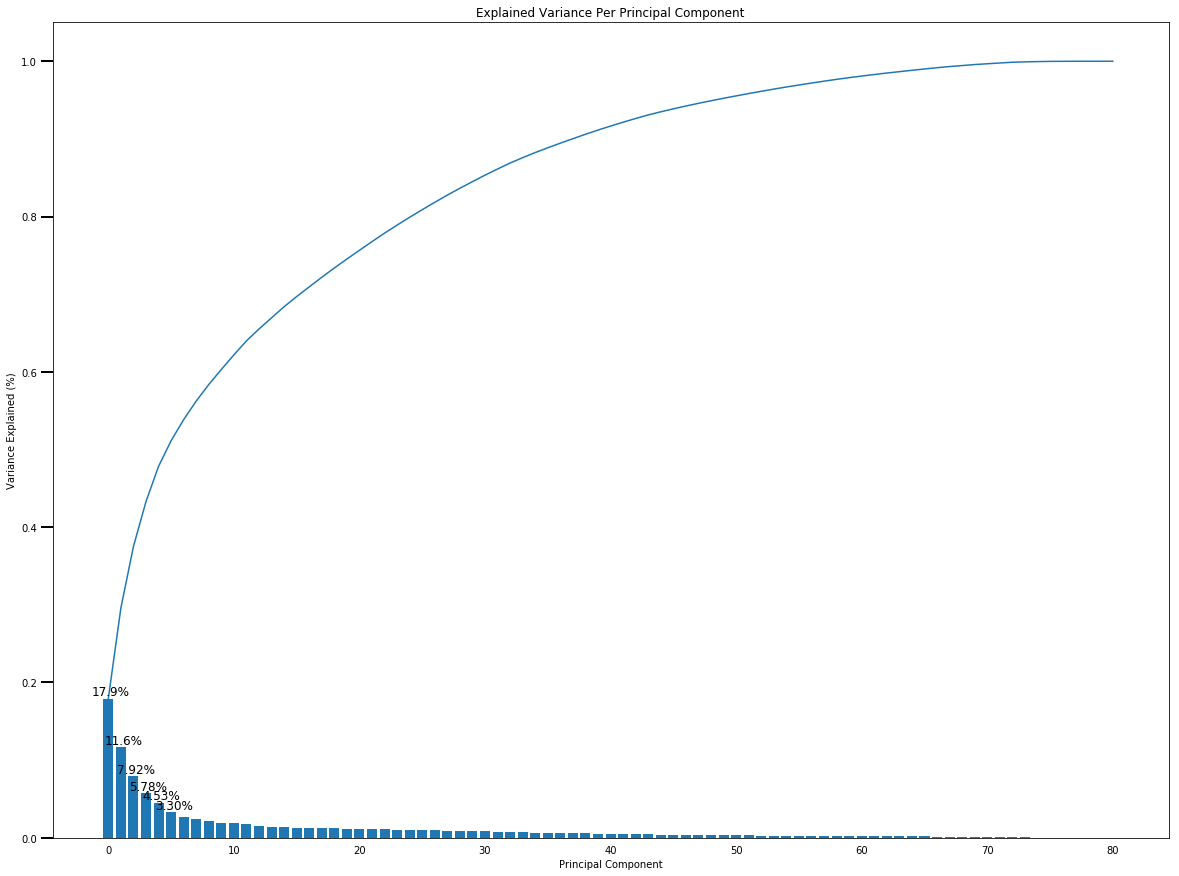

In [86]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(6):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [87]:
#  Checking how many componets are needed to explain at least 85% of the variability in the original dataset.
for comp in range(30, df_clean.shape[1]):
    pca, X_pca = pca_reduction(comp, df_clean)
    sum_pca = sum(pca.explained_variance_ratio_)
    print(sum_pca)
    if sum_pca > 0.85:
        print(comp)
        comp_85 = comp
        break
        

0.844800168041
0.853163132634
31


In [88]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, X_pca = pca_reduction(comp_85, df_clean)

### Discussion 2.2: Perform Dimensionality Reduction

I kept 31 principal components which explain at least 85% of the variability in the original dataset. I wanted to keep as much information of the original dataset as possible to make a meaningful analysis.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [89]:
def pca_feature_weight(full_dataset, pca, comp_number = 0, top=5):
    
    """
    Plots the weights of a specific principal component
    Input:  - the full datasat as a dataframe,
            - corresponding pca (i.e. from pca_reduction)
            - the component number
            - How many top positive/negative number should returned
    Output: - Returns an array with the sorted components as a df
            - and the top 5(by default) negative and positive weights"""
    
    # Dimension indexing
    dimensions = ['Principal Component {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df_clean.keys())
    components.index = dimensions

    fig, ax = plt.subplots(figsize = (14,12))
    
    # sorting components descending
    sorted_components = components.iloc[comp_number].sort_values(ascending=False)
    
    # plotting sorted components as a bar chart
    sorted_components.plot(ax=ax, kind='bar');
    ax.set_ylabel("Feature Weights")
    fig.suptitle(dimensions[comp_number], y = 0.9)
    plt.show();
    
    top_pos = sorted_components.iloc[:top]
    top_neg = sorted_components.iloc[-top:]
    
    return sorted_components, top_pos, top_neg

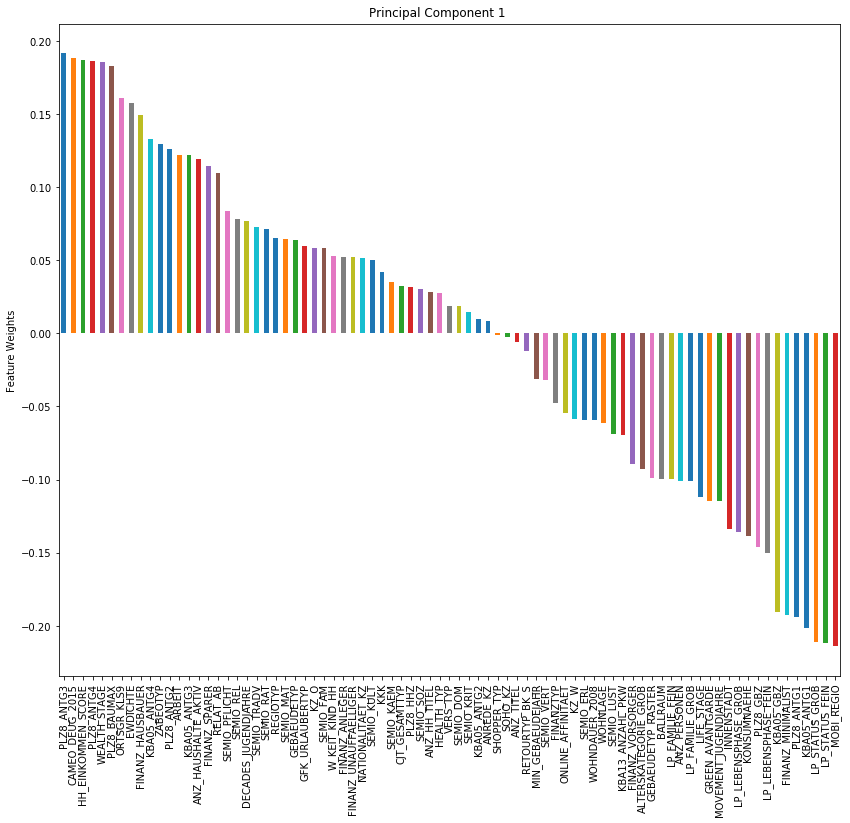

In [90]:
all_componenents, top_pos, top_neg = pca_feature_weight(df_clean, pca, comp_number = 0)

In [91]:
print(top_pos)
print(top_neg)

PLZ8_ANTG3            0.1915
CAMEO_DEUG_2015       0.1885
HH_EINKOMMEN_SCORE    0.1872
PLZ8_ANTG4            0.1861
WEALTH_STAGE          0.1853
Name: Principal Component 1, dtype: float64
PLZ8_ANTG1       -0.1941
KBA05_ANTG1      -0.2018
LP_STATUS_GROB   -0.2109
LP_STATUS_FEIN   -0.2120
MOBI_REGIO       -0.2141
Name: Principal Component 1, dtype: float64


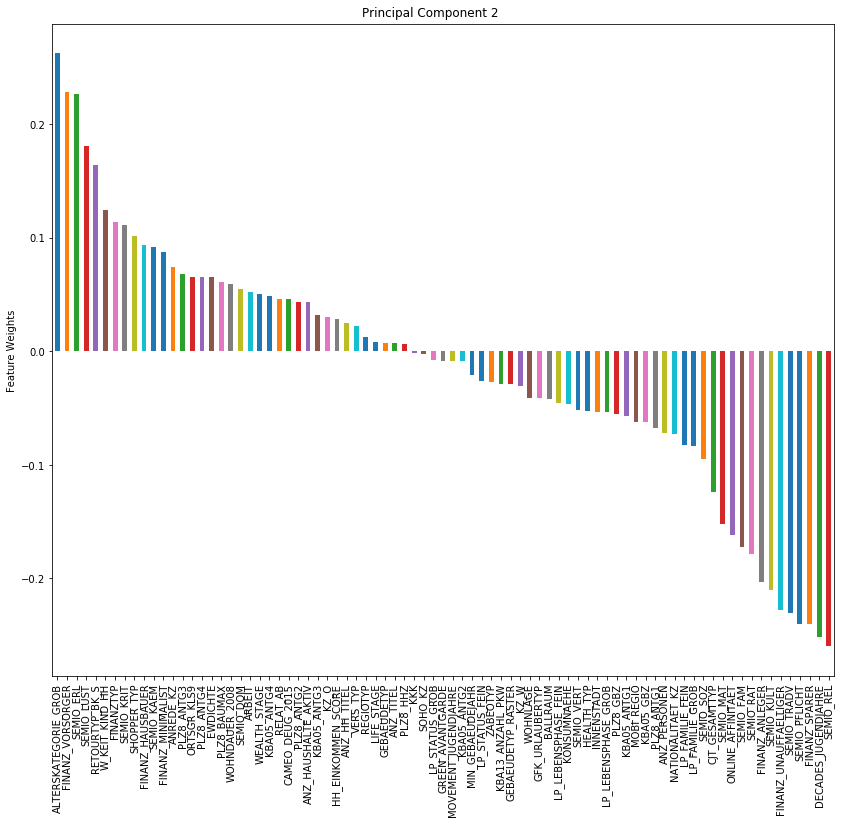

In [92]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
all_componenents, top_pos, top_neg = pca_feature_weight(df_clean, pca, comp_number = 1)


In [93]:
# Printing the Top 5 negative and positive weights for the second component
print(top_pos)
print(top_neg)

ALTERSKATEGORIE_GROB    0.2621
FINANZ_VORSORGER        0.2281
SEMIO_ERL               0.2264
SEMIO_LUST              0.1810
RETOURTYP_BK_S          0.1636
Name: Principal Component 2, dtype: float64
SEMIO_TRADV           -0.2307
SEMIO_PFLICHT         -0.2401
FINANZ_SPARER         -0.2404
DECADES_JUGENDJAHRE   -0.2516
SEMIO_REL             -0.2598
Name: Principal Component 2, dtype: float64


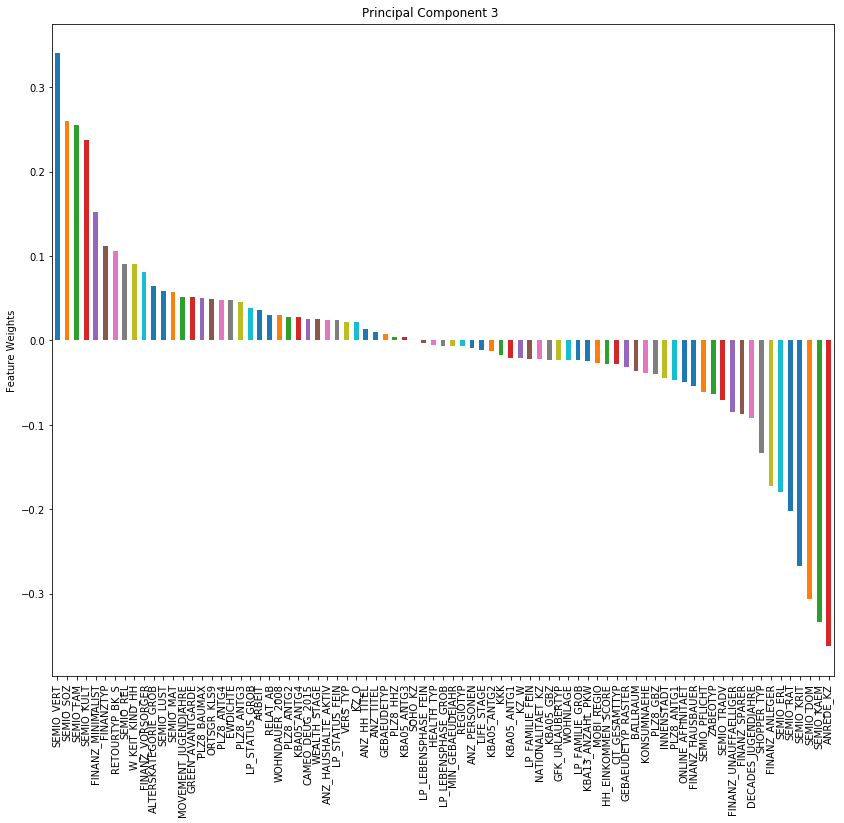

In [94]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
all_componenents, top_pos, top_neg = pca_feature_weight(df_clean, pca, comp_number = 2)


In [95]:
# Printing the Top 5 negative and positive weights for the third component
print(top_pos)
print(top_neg)

SEMIO_VERT           0.3402
SEMIO_SOZ            0.2606
SEMIO_FAM            0.2552
SEMIO_KULT           0.2378
FINANZ_MINIMALIST    0.1518
Name: Principal Component 3, dtype: float64
SEMIO_RAT    -0.2023
SEMIO_KRIT   -0.2669
SEMIO_DOM    -0.3064
SEMIO_KAEM   -0.3334
ANREDE_KZ    -0.3626
Name: Principal Component 3, dtype: float64


### Discussion 2.3: Interpret Principal Components - Correction

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

First Principal Component -  explained_variance: 17.9 %

Top 5 positive weights: <br>
PLZ8_ANTG3:           0.1915 <br>
CAMEO_DEUG_2015:     0.1885 <br>
HH_EINKOMMEN_SCORE:    0.1872 <br>
PLZ8_ANTG4:           0.1861 <br>
WEALTH_STAGE:       0.1853 <br>

Top 5 negative weights:<br>
PLZ8_ANTG1:       -0.1941<br>
KBA05_ANTG1:      -0.2018<br>
LP_STATUS_GROB:  -0.2109<br>
LP_STATUS_FEIN:  -0.2120<br>
MOBI_REGIO:       -0.2141<br>

The first principal component looks related to financial and socialstatus(Cameo, LP-Status) outlook. It's also related to the movement pattern of the people.

First of all a heigh weight or coefficient means that these above mentioned attributes have the heighest impact in the explained variance regardless of negative/positve weight. Positive weight on HH_EINKOMMEN_SCORE, WEALTH_STAGE and negative weight on LP_STATUS indicate that larger compoenent values  indicate more wealthy people and smaller values "poorer" people.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [96]:
df = pd.DataFrame(X_pca)

In [97]:
df = df.sample(frac=0.2, random_state=42)

In [98]:
X_pca_small = df.values

In [99]:
# Over a number of different cluster counts...
score_list = list()
for k in range(1,16):
    # run k-means clustering on the data and...
    kmeans = KMeans(k, random_state=42)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca_small))
    score_list.append(score)
    

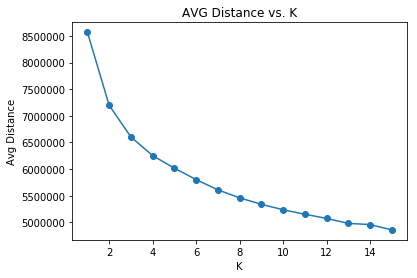

In [100]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
x = np.arange(len(score_list))+1

plt.plot(x, score_list, marker= "o")
plt.xlabel("K")
plt.ylabel("Avg Distance")
plt.title("AVG Distance vs. K");


In [101]:
# Over a number of different cluster counts...
for k in range(16,22):
    # run k-means clustering on the data and...
    kmeans = KMeans(k, random_state=42)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca_small))
    score_list.append(score)
    

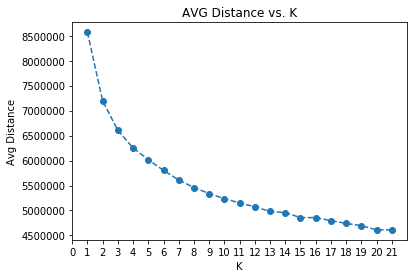

In [102]:
x = np.arange(len(score_list))+1

plt.plot(x, score_list, linestyle="--", marker= "o")
plt.xlabel("K")
plt.xticks(np.arange(0, max(x)+1, 1))
plt.ylabel("Avg Distance")
plt.title("AVG Distance vs. K");


In [103]:
## from sklearn.metrics import silhouette_score

#sil = []
#kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
#for k in range(2, kmax+1):
#    kmeans = KMeans(n_clusters = k, random_state=42).fit(X_pca)
#    labels = kmeans.labels_
#    sil.append(silhouette_score(X_pca[:10000,:], labels[:10000]))

In [104]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

best_k = 15

kmeans_final = KMeans(best_k, random_state=42)
model = kmeans_final.fit(X_pca)

In [105]:
# save centroid points of the KMeans model
centroids = model.cluster_centers_

In [106]:
# check the shape of the centroid points
centroids.shape

(15, 31)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Unfortunately there is no clear elbow point in the "Average Distance vs K"-Plot. Probably it's useful to use other metrics like silhouette score, but this computation takes a lot of time (like the computation of the average distance). I'll separate the data into 15 clusters. There is a "bigger" decreasing step from 14 to 15 clusters and really small step from 15 to 16 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [107]:
def further_engineering(df, pca, scaler):
    """Using the same engineering steps of the general Demographic dataset
    Input:  - Dataframe for wrangling
            - pca object to make the same transformation
            - scaler object to make the same scaling
    
    Output: - transformed data as dataframe (scaled)
            - transformed data with pca
            """
    # Dropping ALTER_HH
    df.drop(columns="ALTER_HH", inplace=True)
    # drop all other nan
    df_drop = df.dropna()
    
    # Standardize Dataframe
    column_names = list(df_drop.columns)
    df_drop = scaler.transform(df_drop)
    df = pd.DataFrame(df_drop, columns = column_names)
    
    # Dimension Reduction via PCA, in this case transform the customer
    # dataframe with the same PCA object 
    X_pca = pca.transform(df)

    return df, X_pca

In [108]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [109]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers = clean_data(customers, feat_info)
df_customers, X_pca_customer = further_engineering(cleaned_customers, pca, scaler)

In [110]:
# predict customer labels with the KMeans model
label_customer = model.predict(X_pca_customer)

In [111]:
# predict general labels with the same KMeans model
label_general = model.predict(X_pca)

In [112]:
# printing the frequencies of labels in the customers data
unique, counts = np.unique(label_customer, return_counts=True)
frequencies_customer = np.asarray((unique, counts)).T
print(frequencies_customer)

[[    0  9149]
 [    1  3360]
 [    2 17404]
 [    3   805]
 [    4 11632]
 [    5   846]
 [    6  7293]
 [    7  1125]
 [    8 27568]
 [    9  7312]
 [   10  6864]
 [   11 13300]
 [   12  5467]
 [   13  1094]
 [   14  2424]]


In [113]:
# printing the frequencies of labels in the general data
(unique, counts) = np.unique(label_general, return_counts=True)
frequencies_general = np.asarray((unique, counts)).T
print(frequencies_general)

[[    0 43647]
 [    1 30907]
 [    2 27976]
 [    3 58962]
 [    4 39216]
 [    5 51636]
 [    6 58092]
 [    7 54813]
 [    8 33288]
 [    9 58341]
 [   10 34618]
 [   11 44055]
 [   12 44287]
 [   13 40838]
 [   14  2533]]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

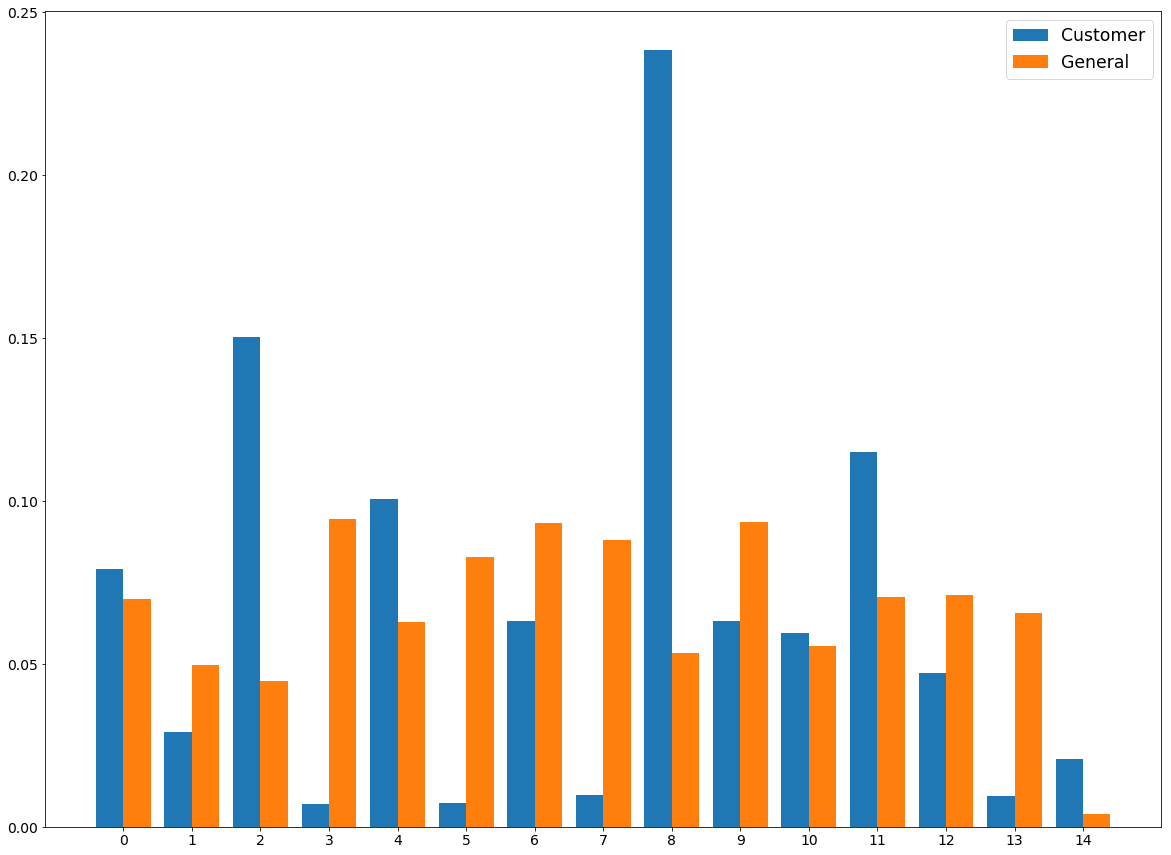

In [114]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
width = 0.4

proportions_customer_clusters = frequencies_customer[:,1] / sum(frequencies_customer[:,1])
proportions_general_clusters = frequencies_general[:,1] / sum(frequencies_general[:,1])

plt.figure(figsize=(20,15))
plt.bar(x=frequencies_customer[:,0] - 0.2, height= proportions_customer_clusters, width = width)
plt.bar(x=frequencies_general[:,0] + 0.2, height= proportions_general_clusters, width = width)
plt.xticks(np.arange(0, max(frequencies_general[:,0])+1, 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Customer', "General"], fontsize= "xx-large");

- Visually Cluster 2, 8 and 11 are overrepresented in the customer data compared to the general distribution
- Visually Cluster 3, 5, 7 and 13 are underrepresented in the customer data compared to the general distribution

In [115]:
def inverse_transformation_centroids(scaler, pca, model_fitted):
    inversed_center = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_))
    return inversed_center
    

In [116]:
inversed_centroids = inverse_transformation_centroids(scaler, pca, model)

In [117]:
inversed_centroids.shape

(15, 81)

In [118]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [119]:
col_names = list(df_customers.columns)

In [120]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_2 = inversed_centroids[2]
cluster_8 = inversed_centroids[8]
cluster_11 = inversed_centroids[11]

In [121]:
df_centroids_customer = pd.DataFrame(data=[cluster_2, cluster_8, cluster_11], index=["Cluster_2", "Cluster_8", "Cluster_11"], columns= col_names)

In [122]:
df_centroids_customer

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,KZ_O,KZ_W,MOVEMENT_JUGENDJAHRE,DECADES_JUGENDJAHRE,WEALTH_STAGE,LIFE_STAGE
Cluster_2,3.357600,1.060040,2.928261,4.828753,1.452406,4.305958,1.232408,2.054583,2.116043,4.864921,6.457912,0.937866,1.965276,14.351479,3.870096,1.748055,1.442036,8.764914,4.400536,1.040491,4.084579,5.330434,4.870589,3.727436,3.904686,6.208703,5.416423,4.131726,4.858831,2.630897,3.415902,3.276344,2.590194,3.157078,3.094927,1.292169,0.007565,1.434292,2.278809,1.397552,0.000839,2.591140,5.365274,8.234657,2.060613,0.005066,2.322996,3.270106,1992.562302,3.020770,3.571447,2.673761,1.208253,0.081998,0.017699,4.047488,3.855040,4.131830,4.458471,3.936970,2.026494,4.056419,2.463693,3.332940,679.253281,2.740975,2.630751,1.234041,0.404220,1.303577,3.716827,3.885742,3.094841,5.576961,3.008172,0.103675,0.896325,1.937866,3.303895,2.132835,3.665512
Cluster_8,3.055146,1.070319,3.445732,4.744193,2.004858,3.921044,1.952053,2.373139,1.701420,4.788288,6.418927,0.797507,2.144002,35.984141,10.803229,9.482554,4.795864,9.131117,4.449794,1.070430,3.641745,5.363885,4.950394,4.069723,3.888039,6.132727,5.017171,3.898007,5.129946,2.949728,2.975159,3.451726,2.646464,3.639907,3.380215,1.191714,0.010723,1.606799,1.933275,3.268265,0.000501,2.504623,2.968396,8.754608,1.543547,0.001010,2.153272,3.435321,1992.628018,3.416052,3.584664,2.759569,1.134328,0.046514,0.010096,4.098016,4.226240,3.769784,4.848574,3.998828,2.292143,4.189397,3.865058,3.639481,710.769054,2.817654,2.572569,1.141171,0.351792,1.175762,3.692552,3.938381,2.916066,5.035725,2.835731,0.076037,0.923963,1.797507,3.985360,2.131661,3.572831
Cluster_11,3.385852,1.942439,3.402985,4.172210,1.656670,4.154573,2.088331,2.233036,2.373835,4.106604,6.521411,0.968681,2.127819,25.320875,7.334123,5.624795,3.135045,8.950718,4.427645,1.051109,3.492952,2.881114,2.037093,2.135935,2.419152,3.106108,5.224707,6.240428,2.076367,3.631710,5.710444,6.221525,5.869150,3.041502,2.945322,2.174833,0.009143,1.525738,2.603353,2.301879,-0.000679,2.485152,3.742568,8.552075,1.369399,0.010355,2.155745,3.414894,1992.548369,3.042662,3.354224,2.839726,1.076075,0.054654,-0.004053,4.125996,3.920927,4.058861,4.576243,3.998364,2.142528,4.227194,3.344301,3.430264,701.078770,2.802108,2.562230,1.191289,0.394607,1.247376,3.732409,3.922812,3.019862,5.512688,2.951170,0.088542,0.911458,1.968681,3.674670,1.999246,3.708254


In [123]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_3 = inversed_centroids[3]
cluster_5 = inversed_centroids[5]
cluster_7 = inversed_centroids[7]
cluster_13 =inversed_centroids[13]

df_centroids_general = pd.DataFrame(data=[cluster_3, cluster_5, cluster_7, cluster_13], index=["Cluster_3", "Cluster_5", "Cluster_7", "cluster_13"], columns= col_names)

In [124]:
df_centroids_general

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,KZ_O,KZ_W,MOVEMENT_JUGENDJAHRE,DECADES_JUGENDJAHRE,WEALTH_STAGE,LIFE_STAGE
Cluster_3,1.506780,2.031252,4.089439,1.128257,4.294498,2.114211,4.145137,3.737143,4.211376,2.199483,8.850453,0.048781,2.189524,9.260771,3.099076,2.984752,1.971183,1.555272,1.003380,1.413462,2.485664,3.366304,3.920108,5.379419,5.209681,2.188713,2.604503,4.067818,4.217303,6.474528,5.612763,6.330645,6.261045,6.446388,6.022299,1.722122,0.007920,1.432148,4.493567,1.461768,-0.000638,5.651022,4.071532,7.153996,14.043359,0.050249,3.493631,2.091960,1992.366895,3.425235,7.540346,0.470809,1.204967,1.191473,0.577313,2.245169,3.260499,5.156008,3.395080,3.405512,2.892333,1.841166,3.008262,5.019293,514.226107,1.435941,3.349011,2.445205,1.296355,3.131303,3.751113,2.681066,3.672413,6.940153,3.723035,0.276743,0.723257,1.048781,5.676382,4.403762,2.028746
Cluster_5,1.796615,0.940183,3.924446,1.886733,4.344034,2.083894,3.477692,3.768278,3.635065,2.838113,8.801448,0.132777,2.370897,8.284357,2.800458,2.619351,1.799712,1.663086,1.117512,1.360800,2.792793,6.530442,6.782900,6.315452,5.159168,6.093479,2.843990,2.053563,7.010572,4.148819,2.731381,2.785820,2.304209,5.711168,4.968929,0.987605,0.008024,1.520657,4.207300,1.434292,-0.000715,5.583831,4.485248,7.091666,15.586429,0.055089,3.563907,2.056864,1992.377185,3.576630,7.701538,0.390013,1.180538,1.175398,0.640806,2.159563,3.151092,5.157990,3.295295,3.331970,2.925982,1.737443,2.894250,4.981723,505.977095,1.383684,3.313336,2.475850,1.349928,3.263896,3.756746,2.608976,3.704123,7.021908,3.727704,0.318350,0.681650,1.132777,5.694456,4.481167,1.931530
Cluster_7,1.611497,2.004980,4.006315,2.192996,4.012724,2.208298,4.389431,3.843963,3.002348,2.419998,7.910087,0.174484,2.186456,17.842059,5.501074,4.986310,2.849358,5.249687,2.494537,1.316892,2.308932,3.007555,3.671576,5.238893,5.098280,2.427624,2.870129,4.164034,4.108875,6.387664,5.481402,6.143329,5.738852,6.283487,6.020507,1.538048,0.008747,1.421542,3.873039,2.016182,0.001182,4.309026,3.266331,7.557166,3.665968,-0.000647,2.574320,3.616099,1992.703146,4.542734,4.319608,2.178859,1.451025,0.271046,0.065960,3.823860,4.856256,3.097011,5.387540,3.989856,2.638304,3.723027,3.620453,4.191576,699.164907,2.855548,2.452824,0.989686,0.248220,1.059068,3.549102,3.939049,2.796756,4.074003,2.564786,0.138050,0.861950,1.174484,5.708305,2.552339,3.257230
cluster_13,1.700662,0.943335,4.331520,2.874811,4.168022,2.154124,3.894261,4.008590,2.511176,2.792926,7.802171,0.271246,2.216436,18.087429,5.588754,5.062809,2.871031,5.477493,2.628807,1.251572,2.401853,6.313136,6.600525,6.481388,5.200986,6.275715,2.972970,1.946839,7.046283,4.350924,2.282527,2.504017,1.807417,5.910341,5.202723,0.826404,0.009941,1.472498,2.804630,2.162833,0.000108,4.052370,3.709190,7.611258,3.944827,0.005277,2.663306,3.589743,1992.662697,4.665277,4.451072,2.117530,1.497131,0.324948,0.068190,3.770113,4.795042,3.085559,5.360097,3.970166,2.694320,3.665432,3.886495,4.249658,694.831311,2.814247,2.481088,1.033110,0.271142,1.125928,3.554554,3.901519,2.866196,4.111655,2.659492,0.161768,0.838232,1.271246,5.76

### Discussion 3.3: Compare Customer Data to Demographics Data

- Visually Cluster 2, 8 and 11 are overrepresented in the customer data compared to the general distribution
- Visually Cluster 3, 5, 7 and 13 are underrepresented in the customer data compared to the general distribution



The difference between the customer set and general population in Cluster 8 is huge. (~24% to ~5%). These group of persons are more likely to be male and in an age range from 46-60 years(Label 3). In cluster 2 and cluster 11 the age range is similar near label 3. The suggestion is that the companies target customergroup is in the age range from 46-60 years. In contrast to that younger people (Label 1 and 2, <30 years or 30-45 years) are underrepresented and probably not using the mail order sales of this company.

The CJT Typ(Customer Journey Typology) differs too. Customers are more likely to be advertisinginterested Store-shopper (Label 3) and there is underrepresentation of people more likely to be advertisinginterested Online-shopper (Label 4). So it can be target-oriented to make advertising near stores and in public areas. Or the company need to make an offensive online advertising strategy to expand their market share.

Customers are more likely to be money-savers which the FINANZ_SPARER column indicates(Label 1-2: Very High - High). So it can be helpful to make more discount/coupon campaigns periodically to increase to market share of the company.

Customers tends to be Hikers and/or Golden Agers which is indicated by the GFK_URLAUBERTYP (Label 7 and Label 8). It can be useful to extend the product range of Hiking stuff (Outdoor jackets, hiking boots etc.)

Looking to the LP_STATUS_FEIN which represents the social status, customers are housewoners (Label 9: Houseowner) in all 3 clusters. The company is underreprented in low income earners - average earners as shown in cluster 3,5,7 and 13. The company should decide if it like to be more exclusive for more wealthy people or more accessable for lower income earners.


Conclusion: <br>
The company needs to expand their market shares in the younger population to compete with other mail-order sales companies. As mentioned customers are more likely to be wealthy and in there "golden Age" time. It could be useful to offer high quality(expensive) products in segments like Hiking/Outdoor. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.